In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:54 - loss: 2.5766 - STD: 0.1253 - MAE: 0.2186

  4/395 [..............................] - ETA: 7s - loss: 2.2702 - STD: 0.0781 - MAE: 0.2168  

  8/395 [..............................] - ETA: 6s - loss: 2.1788 - STD: 0.0592 - MAE: 0.2170

 12/395 [..............................] - ETA: 6s - loss: 2.1545 - STD: 0.0561 - MAE: 0.2169

 16/395 [>.............................] - ETA: 5s - loss: 2.1315 - STD: 0.0523 - MAE: 0.2168

 20/395 [>.............................] - ETA: 5s - loss: 2.1162 - STD: 0.0482 - MAE: 0.2168

 23/395 [>.............................] - ETA: 5s - loss: 2.1090 - STD: 0.0462 - MAE: 0.2168

 27/395 [=>............................] - ETA: 5s - loss: 2.1017 - STD: 0.0447 - MAE: 0.2168

 31/395 [=>............................] - ETA: 5s - loss: 2.0949 - STD: 0.0434 - MAE: 0.2167

 35/395 [=>............................] - ETA: 5s - loss: 2.0903 - STD: 0.0421 - MAE: 0.2167

 39/395 [=>............................] - ETA: 5s - loss: 2.0863 - STD: 0.0409 - MAE: 0.2168

 43/395 [==>...........................] - ETA: 5s - loss: 2.0828 - STD: 0.0403 - MAE: 0.2167

 47/395 [==>...........................] - ETA: 5s - loss: 2.0796 - STD: 0.0398 - MAE: 0.2167

 51/395 [==>...........................] - ETA: 5s - loss: 2.0766 - STD: 0.0390 - MAE: 0.2167

 55/395 [===>..........................] - ETA: 5s - loss: 2.0736 - STD: 0.0385 - MAE: 0.2166

 59/395 [===>..........................] - ETA: 5s - loss: 2.0700 - STD: 0.0382 - MAE: 0.2166

 63/395 [===>..........................] - ETA: 5s - loss: 2.0657 - STD: 0.0381 - MAE: 0.2164

 67/395 [====>.........................] - ETA: 5s - loss: 2.0600 - STD: 0.0382 - MAE: 0.2163

 71/395 [====>.........................] - ETA: 5s - loss: 2.0534 - STD: 0.0388 - MAE: 0.2160

 74/395 [====>.........................] - ETA: 5s - loss: 2.0477 - STD: 0.0394 - MAE: 0.2158

 77/395 [====>.........................] - ETA: 5s - loss: 2.0416 - STD: 0.0403 - MAE: 0.2155

 81/395 [=====>........................] - ETA: 4s - loss: 2.0327 - STD: 0.0417 - MAE: 0.2150

 85/395 [=====>........................] - ETA: 4s - loss: 2.0235 - STD: 0.0431 - MAE: 0.2146

 89/395 [=====>........................] - ETA: 4s - loss: 2.0137 - STD: 0.0446 - MAE: 0.2141

 93/395 [======>.......................] - ETA: 4s - loss: 2.0033 - STD: 0.0463 - MAE: 0.2136

 97/395 [======>.......................] - ETA: 4s - loss: 1.9920 - STD: 0.0479 - MAE: 0.2130

101/395 [======>.......................] - ETA: 4s - loss: 1.9799 - STD: 0.0496 - MAE: 0.2124

105/395 [======>.......................] - ETA: 4s - loss: 1.9666 - STD: 0.0515 - MAE: 0.2117

108/395 [=======>......................] - ETA: 4s - loss: 1.9561 - STD: 0.0530 - MAE: 0.2111

112/395 [=======>......................] - ETA: 4s - loss: 1.9418 - STD: 0.0552 - MAE: 0.2103

115/395 [=======>......................] - ETA: 4s - loss: 1.9312 - STD: 0.0570 - MAE: 0.2096

119/395 [========>.....................] - ETA: 4s - loss: 1.9170 - STD: 0.0593 - MAE: 0.2087

123/395 [========>.....................] - ETA: 4s - loss: 1.9029 - STD: 0.0617 - MAE: 0.2078

127/395 [========>.....................] - ETA: 4s - loss: 1.8893 - STD: 0.0640 - MAE: 0.2069

131/395 [========>.....................] - ETA: 4s - loss: 1.8762 - STD: 0.0662 - MAE: 0.2060

135/395 [=========>....................] - ETA: 4s - loss: 1.8634 - STD: 0.0683 - MAE: 0.2052

139/395 [=========>....................] - ETA: 4s - loss: 1.8509 - STD: 0.0703 - MAE: 0.2044

142/395 [=========>....................] - ETA: 3s - loss: 1.8419 - STD: 0.0718 - MAE: 0.2038

145/395 [==========>...................] - ETA: 3s - loss: 1.8331 - STD: 0.0733 - MAE: 0.2032

149/395 [==========>...................] - ETA: 3s - loss: 1.8216 - STD: 0.0752 - MAE: 0.2024

153/395 [==========>...................] - ETA: 3s - loss: 1.8108 - STD: 0.0770 - MAE: 0.2017

157/395 [==========>...................] - ETA: 3s - loss: 1.8001 - STD: 0.0788 - MAE: 0.2009

161/395 [===========>..................] - ETA: 3s - loss: 1.7898 - STD: 0.0805 - MAE: 0.2002

165/395 [===========>..................] - ETA: 3s - loss: 1.7799 - STD: 0.0821 - MAE: 0.1996

168/395 [===========>..................] - ETA: 4s - loss: 1.7739 - STD: 0.0833 - MAE: 0.1991

172/395 [============>.................] - ETA: 4s - loss: 1.7644 - STD: 0.0848 - MAE: 0.1984

176/395 [============>.................] - ETA: 4s - loss: 1.7550 - STD: 0.0863 - MAE: 0.1978

180/395 [============>.................] - ETA: 4s - loss: 1.7461 - STD: 0.0877 - MAE: 0.1972

184/395 [============>.................] - ETA: 4s - loss: 1.7374 - STD: 0.0892 - MAE: 0.1965

188/395 [=============>................] - ETA: 3s - loss: 1.7289 - STD: 0.0905 - MAE: 0.1959

192/395 [=============>................] - ETA: 3s - loss: 1.7206 - STD: 0.0918 - MAE: 0.1954

196/395 [=============>................] - ETA: 3s - loss: 1.7127 - STD: 0.0931 - MAE: 0.1948

200/395 [==============>...............] - ETA: 3s - loss: 1.7049 - STD: 0.0944 - MAE: 0.1942

204/395 [==============>...............] - ETA: 3s - loss: 1.6971 - STD: 0.0956 - MAE: 0.1937

208/395 [==============>...............] - ETA: 3s - loss: 1.6899 - STD: 0.0968 - MAE: 0.1932

211/395 [===============>..............] - ETA: 3s - loss: 1.6844 - STD: 0.0976 - MAE: 0.1928

215/395 [===============>..............] - ETA: 3s - loss: 1.6773 - STD: 0.0988 - MAE: 0.1922

219/395 [===============>..............] - ETA: 3s - loss: 1.6703 - STD: 0.0999 - MAE: 0.1917

223/395 [===============>..............] - ETA: 3s - loss: 1.6636 - STD: 0.1010 - MAE: 0.1912

227/395 [================>.............] - ETA: 3s - loss: 1.6571 - STD: 0.1021 - MAE: 0.1907

231/395 [================>.............] - ETA: 3s - loss: 1.6506 - STD: 0.1031 - MAE: 0.1902

235/395 [================>.............] - ETA: 2s - loss: 1.6442 - STD: 0.1041 - MAE: 0.1898

239/395 [=================>............] - ETA: 2s - loss: 1.6383 - STD: 0.1051 - MAE: 0.1893

243/395 [=================>............] - ETA: 2s - loss: 1.6323 - STD: 0.1061 - MAE: 0.1888

247/395 [=================>............] - ETA: 2s - loss: 1.6265 - STD: 0.1071 - MAE: 0.1884

251/395 [==================>...........] - ETA: 2s - loss: 1.6207 - STD: 0.1081 - MAE: 0.1879

255/395 [==================>...........] - ETA: 2s - loss: 1.6152 - STD: 0.1090 - MAE: 0.1875

259/395 [==================>...........] - ETA: 2s - loss: 1.6096 - STD: 0.1099 - MAE: 0.1870

263/395 [==================>...........] - ETA: 2s - loss: 1.6042 - STD: 0.1108 - MAE: 0.1866

267/395 [===================>..........] - ETA: 2s - loss: 1.5988 - STD: 0.1117 - MAE: 0.1862

271/395 [===================>..........] - ETA: 2s - loss: 1.5935 - STD: 0.1126 - MAE: 0.1858

275/395 [===================>..........] - ETA: 2s - loss: 1.5883 - STD: 0.1134 - MAE: 0.1853

278/395 [====================>.........] - ETA: 2s - loss: 1.5844 - STD: 0.1140 - MAE: 0.1850

282/395 [====================>.........] - ETA: 2s - loss: 1.5792 - STD: 0.1149 - MAE: 0.1846

286/395 [====================>.........] - ETA: 1s - loss: 1.5742 - STD: 0.1157 - MAE: 0.1842

290/395 [=====================>........] - ETA: 1s - loss: 1.5693 - STD: 0.1165 - MAE: 0.1838

294/395 [=====================>........] - ETA: 1s - loss: 1.5644 - STD: 0.1173 - MAE: 0.1834

298/395 [=====================>........] - ETA: 1s - loss: 1.5597 - STD: 0.1181 - MAE: 0.1830

302/395 [=====================>........] - ETA: 1s - loss: 1.5551 - STD: 0.1189 - MAE: 0.1826

306/395 [======================>.......] - ETA: 1s - loss: 1.5505 - STD: 0.1197 - MAE: 0.1822

310/395 [======================>.......] - ETA: 1s - loss: 1.5460 - STD: 0.1204 - MAE: 0.1818

314/395 [======================>.......] - ETA: 1s - loss: 1.5414 - STD: 0.1212 - MAE: 0.1815

318/395 [=======================>......] - ETA: 1s - loss: 1.5370 - STD: 0.1219 - MAE: 0.1811

322/395 [=======================>......] - ETA: 1s - loss: 1.5326 - STD: 0.1226 - MAE: 0.1807

326/395 [=======================>......] - ETA: 1s - loss: 1.5284 - STD: 0.1233 - MAE: 0.1804

330/395 [========================>.....] - ETA: 1s - loss: 1.5244 - STD: 0.1240 - MAE: 0.1800

333/395 [========================>.....] - ETA: 1s - loss: 1.5214 - STD: 0.1246 - MAE: 0.1798

337/395 [========================>.....] - ETA: 1s - loss: 1.5174 - STD: 0.1252 - MAE: 0.1794

341/395 [========================>.....] - ETA: 0s - loss: 1.5133 - STD: 0.1259 - MAE: 0.1791

345/395 [=========================>....] - ETA: 0s - loss: 1.5095 - STD: 0.1266 - MAE: 0.1787

349/395 [=========================>....] - ETA: 0s - loss: 1.5058 - STD: 0.1272 - MAE: 0.1784

353/395 [=========================>....] - ETA: 0s - loss: 1.5021 - STD: 0.1279 - MAE: 0.1781

357/395 [==========================>...] - ETA: 0s - loss: 1.4984 - STD: 0.1285 - MAE: 0.1778

361/395 [==========================>...] - ETA: 0s - loss: 1.4948 - STD: 0.1291 - MAE: 0.1774

364/395 [==========================>...] - ETA: 0s - loss: 1.4922 - STD: 0.1295 - MAE: 0.1772

368/395 [==========================>...] - ETA: 0s - loss: 1.4887 - STD: 0.1301 - MAE: 0.1769

371/395 [===========================>..] - ETA: 0s - loss: 1.4861 - STD: 0.1306 - MAE: 0.1767

375/395 [===========================>..] - ETA: 0s - loss: 1.4827 - STD: 0.1312 - MAE: 0.1764

379/395 [===========================>..] - ETA: 0s - loss: 1.4792 - STD: 0.1317 - MAE: 0.1761

383/395 [============================>.] - ETA: 0s - loss: 1.4758 - STD: 0.1323 - MAE: 0.1758

387/395 [============================>.] - ETA: 0s - loss: 1.4725 - STD: 0.1329 - MAE: 0.1755

390/395 [============================>.] - ETA: 0s - loss: 1.4700 - STD: 0.1333 - MAE: 0.1753

394/395 [============================>.] - ETA: 0s - loss: 1.4668 - STD: 0.1338 - MAE: 0.1750

395/395 [==============================] - 9s 20ms/step - loss: 1.4660 - STD: 0.1340 - MAE: 0.1749 - val_loss: 1.2020 - val_STD: 0.1882 - val_MAE: 0.1482


Epoch 2/10000


  1/395 [..............................] - ETA: 15s - loss: 1.1534 - STD: 0.1860 - MAE: 0.1476

  4/395 [..............................] - ETA: 6s - loss: 1.1550 - STD: 0.1867 - MAE: 0.1475 

  8/395 [..............................] - ETA: 6s - loss: 1.1495 - STD: 0.1867 - MAE: 0.1472

 12/395 [..............................] - ETA: 5s - loss: 1.1482 - STD: 0.1870 - MAE: 0.1470

 16/395 [>.............................] - ETA: 5s - loss: 1.1486 - STD: 0.1874 - MAE: 0.1468

 20/395 [>.............................] - ETA: 5s - loss: 1.1477 - STD: 0.1876 - MAE: 0.1467

 24/395 [>.............................] - ETA: 5s - loss: 1.1475 - STD: 0.1878 - MAE: 0.1466

 28/395 [=>............................] - ETA: 5s - loss: 1.1465 - STD: 0.1879 - MAE: 0.1465

 32/395 [=>............................] - ETA: 5s - loss: 1.1455 - STD: 0.1879 - MAE: 0.1465

 36/395 [=>............................] - ETA: 5s - loss: 1.1499 - STD: 0.1880 - MAE: 0.1467

 40/395 [==>...........................] - ETA: 5s - loss: 1.1496 - STD: 0.1882 - MAE: 0.1466

 44/395 [==>...........................] - ETA: 5s - loss: 1.1484 - STD: 0.1884 - MAE: 0.1465

 48/395 [==>...........................] - ETA: 5s - loss: 1.1478 - STD: 0.1885 - MAE: 0.1464

 51/395 [==>...........................] - ETA: 5s - loss: 1.1472 - STD: 0.1886 - MAE: 0.1463

 55/395 [===>..........................] - ETA: 5s - loss: 1.1470 - STD: 0.1886 - MAE: 0.1463

 59/395 [===>..........................] - ETA: 5s - loss: 1.1472 - STD: 0.1887 - MAE: 0.1463

 63/395 [===>..........................] - ETA: 5s - loss: 1.1473 - STD: 0.1887 - MAE: 0.1463

 67/395 [====>.........................] - ETA: 5s - loss: 1.1471 - STD: 0.1888 - MAE: 0.1463

 71/395 [====>.........................] - ETA: 4s - loss: 1.1462 - STD: 0.1888 - MAE: 0.1462

 75/395 [====>.........................] - ETA: 4s - loss: 1.1450 - STD: 0.1890 - MAE: 0.1461

 79/395 [=====>........................] - ETA: 4s - loss: 1.1437 - STD: 0.1891 - MAE: 0.1460

 83/395 [=====>........................] - ETA: 4s - loss: 1.1425 - STD: 0.1892 - MAE: 0.1459

 87/395 [=====>........................] - ETA: 4s - loss: 1.1418 - STD: 0.1893 - MAE: 0.1458

 91/395 [=====>........................] - ETA: 4s - loss: 1.1406 - STD: 0.1894 - MAE: 0.1457

 95/395 [======>.......................] - ETA: 4s - loss: 1.1400 - STD: 0.1895 - MAE: 0.1456

 99/395 [======>.......................] - ETA: 4s - loss: 1.1396 - STD: 0.1896 - MAE: 0.1456

103/395 [======>.......................] - ETA: 4s - loss: 1.1392 - STD: 0.1897 - MAE: 0.1455

107/395 [=======>......................] - ETA: 4s - loss: 1.1386 - STD: 0.1898 - MAE: 0.1454

111/395 [=======>......................] - ETA: 4s - loss: 1.1377 - STD: 0.1899 - MAE: 0.1454

115/395 [=======>......................] - ETA: 4s - loss: 1.1366 - STD: 0.1900 - MAE: 0.1453

119/395 [========>.....................] - ETA: 4s - loss: 1.1358 - STD: 0.1902 - MAE: 0.1452

123/395 [========>.....................] - ETA: 4s - loss: 1.1347 - STD: 0.1903 - MAE: 0.1451

127/395 [========>.....................] - ETA: 4s - loss: 1.1339 - STD: 0.1903 - MAE: 0.1450

131/395 [========>.....................] - ETA: 4s - loss: 1.1328 - STD: 0.1904 - MAE: 0.1449

135/395 [=========>....................] - ETA: 4s - loss: 1.1318 - STD: 0.1906 - MAE: 0.1448

139/395 [=========>....................] - ETA: 3s - loss: 1.1310 - STD: 0.1907 - MAE: 0.1447

143/395 [=========>....................] - ETA: 3s - loss: 1.1301 - STD: 0.1908 - MAE: 0.1447

147/395 [==========>...................] - ETA: 3s - loss: 1.1293 - STD: 0.1909 - MAE: 0.1446

150/395 [==========>...................] - ETA: 3s - loss: 1.1286 - STD: 0.1910 - MAE: 0.1445

154/395 [==========>...................] - ETA: 3s - loss: 1.1280 - STD: 0.1911 - MAE: 0.1444

158/395 [===========>..................] - ETA: 3s - loss: 1.1271 - STD: 0.1912 - MAE: 0.1443

162/395 [===========>..................] - ETA: 3s - loss: 1.1264 - STD: 0.1913 - MAE: 0.1443

166/395 [===========>..................] - ETA: 3s - loss: 1.1257 - STD: 0.1914 - MAE: 0.1442

170/395 [===========>..................] - ETA: 3s - loss: 1.1250 - STD: 0.1915 - MAE: 0.1441

174/395 [============>.................] - ETA: 3s - loss: 1.1244 - STD: 0.1916 - MAE: 0.1440

178/395 [============>.................] - ETA: 3s - loss: 1.1237 - STD: 0.1917 - MAE: 0.1440

182/395 [============>.................] - ETA: 3s - loss: 1.1230 - STD: 0.1918 - MAE: 0.1439

186/395 [=============>................] - ETA: 3s - loss: 1.1224 - STD: 0.1919 - MAE: 0.1438

190/395 [=============>................] - ETA: 3s - loss: 1.1221 - STD: 0.1920 - MAE: 0.1438

194/395 [=============>................] - ETA: 3s - loss: 1.1216 - STD: 0.1921 - MAE: 0.1437

198/395 [==============>...............] - ETA: 3s - loss: 1.1211 - STD: 0.1922 - MAE: 0.1437

202/395 [==============>...............] - ETA: 2s - loss: 1.1203 - STD: 0.1922 - MAE: 0.1436

206/395 [==============>...............] - ETA: 2s - loss: 1.1199 - STD: 0.1923 - MAE: 0.1435

210/395 [==============>...............] - ETA: 2s - loss: 1.1195 - STD: 0.1924 - MAE: 0.1435

214/395 [===============>..............] - ETA: 2s - loss: 1.1190 - STD: 0.1925 - MAE: 0.1434

218/395 [===============>..............] - ETA: 2s - loss: 1.1182 - STD: 0.1926 - MAE: 0.1434

222/395 [===============>..............] - ETA: 2s - loss: 1.1176 - STD: 0.1926 - MAE: 0.1433

226/395 [================>.............] - ETA: 2s - loss: 1.1170 - STD: 0.1927 - MAE: 0.1432

230/395 [================>.............] - ETA: 2s - loss: 1.1163 - STD: 0.1928 - MAE: 0.1432

234/395 [================>.............] - ETA: 2s - loss: 1.1156 - STD: 0.1929 - MAE: 0.1431

238/395 [=================>............] - ETA: 2s - loss: 1.1149 - STD: 0.1929 - MAE: 0.1430

241/395 [=================>............] - ETA: 2s - loss: 1.1145 - STD: 0.1930 - MAE: 0.1430

245/395 [=================>............] - ETA: 2s - loss: 1.1142 - STD: 0.1931 - MAE: 0.1429

249/395 [=================>............] - ETA: 2s - loss: 1.1137 - STD: 0.1932 - MAE: 0.1429

253/395 [==================>...........] - ETA: 2s - loss: 1.1131 - STD: 0.1933 - MAE: 0.1428

257/395 [==================>...........] - ETA: 2s - loss: 1.1123 - STD: 0.1933 - MAE: 0.1427

261/395 [==================>...........] - ETA: 2s - loss: 1.1117 - STD: 0.1934 - MAE: 0.1427

265/395 [===================>..........] - ETA: 2s - loss: 1.1111 - STD: 0.1935 - MAE: 0.1426

269/395 [===================>..........] - ETA: 1s - loss: 1.1104 - STD: 0.1936 - MAE: 0.1425

273/395 [===================>..........] - ETA: 1s - loss: 1.1097 - STD: 0.1937 - MAE: 0.1425

277/395 [====================>.........] - ETA: 1s - loss: 1.1089 - STD: 0.1938 - MAE: 0.1424

281/395 [====================>.........] - ETA: 1s - loss: 1.1083 - STD: 0.1938 - MAE: 0.1423

285/395 [====================>.........] - ETA: 1s - loss: 1.1077 - STD: 0.1939 - MAE: 0.1423

289/395 [====================>.........] - ETA: 1s - loss: 1.1071 - STD: 0.1940 - MAE: 0.1422

293/395 [=====================>........] - ETA: 1s - loss: 1.1065 - STD: 0.1941 - MAE: 0.1422

297/395 [=====================>........] - ETA: 1s - loss: 1.1059 - STD: 0.1941 - MAE: 0.1421

301/395 [=====================>........] - ETA: 1s - loss: 1.1054 - STD: 0.1942 - MAE: 0.1420

305/395 [======================>.......] - ETA: 1s - loss: 1.1051 - STD: 0.1943 - MAE: 0.1420

309/395 [======================>.......] - ETA: 1s - loss: 1.1045 - STD: 0.1944 - MAE: 0.1419

313/395 [======================>.......] - ETA: 1s - loss: 1.1042 - STD: 0.1944 - MAE: 0.1419

316/395 [=======================>......] - ETA: 1s - loss: 1.1039 - STD: 0.1945 - MAE: 0.1419

320/395 [=======================>......] - ETA: 1s - loss: 1.1034 - STD: 0.1946 - MAE: 0.1418

324/395 [=======================>......] - ETA: 1s - loss: 1.1029 - STD: 0.1946 - MAE: 0.1418

328/395 [=======================>......] - ETA: 1s - loss: 1.1023 - STD: 0.1947 - MAE: 0.1417

332/395 [========================>.....] - ETA: 0s - loss: 1.1017 - STD: 0.1947 - MAE: 0.1417

336/395 [========================>.....] - ETA: 0s - loss: 1.1013 - STD: 0.1948 - MAE: 0.1416

340/395 [========================>.....] - ETA: 0s - loss: 1.1008 - STD: 0.1949 - MAE: 0.1416

344/395 [=========================>....] - ETA: 0s - loss: 1.1002 - STD: 0.1949 - MAE: 0.1415

348/395 [=========================>....] - ETA: 0s - loss: 1.0998 - STD: 0.1950 - MAE: 0.1415

352/395 [=========================>....] - ETA: 0s - loss: 1.0992 - STD: 0.1951 - MAE: 0.1414

356/395 [==========================>...] - ETA: 0s - loss: 1.0986 - STD: 0.1951 - MAE: 0.1413

360/395 [==========================>...] - ETA: 0s - loss: 1.0981 - STD: 0.1952 - MAE: 0.1413

364/395 [==========================>...] - ETA: 0s - loss: 1.0976 - STD: 0.1953 - MAE: 0.1412

368/395 [==========================>...] - ETA: 0s - loss: 1.0970 - STD: 0.1953 - MAE: 0.1412

372/395 [===========================>..] - ETA: 0s - loss: 1.0964 - STD: 0.1954 - MAE: 0.1411

376/395 [===========================>..] - ETA: 0s - loss: 1.0958 - STD: 0.1955 - MAE: 0.1411

380/395 [===========================>..] - ETA: 0s - loss: 1.0952 - STD: 0.1955 - MAE: 0.1410

384/395 [============================>.] - ETA: 0s - loss: 1.0948 - STD: 0.1956 - MAE: 0.1409

388/395 [============================>.] - ETA: 0s - loss: 1.0941 - STD: 0.1957 - MAE: 0.1409

392/395 [============================>.] - ETA: 0s - loss: 1.0936 - STD: 0.1958 - MAE: 0.1408

395/395 [==============================] - 7s 17ms/step - loss: 1.0932 - STD: 0.1958 - MAE: 0.1408 - val_loss: 1.1088 - val_STD: 0.2049 - val_MAE: 0.1372


Epoch 3/10000


  1/395 [..............................] - ETA: 18s - loss: 1.0314 - STD: 0.2015 - MAE: 0.1352

  4/395 [..............................] - ETA: 7s - loss: 1.0371 - STD: 0.2024 - MAE: 0.1352 

  8/395 [..............................] - ETA: 6s - loss: 1.0318 - STD: 0.2027 - MAE: 0.1348

 12/395 [..............................] - ETA: 6s - loss: 1.0314 - STD: 0.2028 - MAE: 0.1348

 16/395 [>.............................] - ETA: 5s - loss: 1.0323 - STD: 0.2026 - MAE: 0.1349

 20/395 [>.............................] - ETA: 5s - loss: 1.0323 - STD: 0.2026 - MAE: 0.1349

 24/395 [>.............................] - ETA: 5s - loss: 1.0355 - STD: 0.2026 - MAE: 0.1351

 28/395 [=>............................] - ETA: 5s - loss: 1.0355 - STD: 0.2027 - MAE: 0.1351

 32/395 [=>............................] - ETA: 5s - loss: 1.0346 - STD: 0.2029 - MAE: 0.1349

 35/395 [=>............................] - ETA: 5s - loss: 1.0343 - STD: 0.2029 - MAE: 0.1349

 39/395 [=>............................] - ETA: 5s - loss: 1.0335 - STD: 0.2031 - MAE: 0.1348

 43/395 [==>...........................] - ETA: 5s - loss: 1.0348 - STD: 0.2031 - MAE: 0.1348

 47/395 [==>...........................] - ETA: 5s - loss: 1.0350 - STD: 0.2032 - MAE: 0.1348

 51/395 [==>...........................] - ETA: 5s - loss: 1.0360 - STD: 0.2034 - MAE: 0.1348

 55/395 [===>..........................] - ETA: 5s - loss: 1.0370 - STD: 0.2035 - MAE: 0.1348

 58/395 [===>..........................] - ETA: 5s - loss: 1.0366 - STD: 0.2034 - MAE: 0.1348

 62/395 [===>..........................] - ETA: 5s - loss: 1.0358 - STD: 0.2034 - MAE: 0.1348

 65/395 [===>..........................] - ETA: 5s - loss: 1.0348 - STD: 0.2033 - MAE: 0.1347

 68/395 [====>.........................] - ETA: 5s - loss: 1.0343 - STD: 0.2034 - MAE: 0.1347

 71/395 [====>.........................] - ETA: 5s - loss: 1.0336 - STD: 0.2034 - MAE: 0.1346

 74/395 [====>.........................] - ETA: 5s - loss: 1.0330 - STD: 0.2034 - MAE: 0.1346

 77/395 [====>.........................] - ETA: 5s - loss: 1.0331 - STD: 0.2035 - MAE: 0.1346

 80/395 [=====>........................] - ETA: 5s - loss: 1.0323 - STD: 0.2035 - MAE: 0.1345

 83/395 [=====>........................] - ETA: 5s - loss: 1.0317 - STD: 0.2036 - MAE: 0.1345

 86/395 [=====>........................] - ETA: 5s - loss: 1.0314 - STD: 0.2036 - MAE: 0.1344

 89/395 [=====>........................] - ETA: 4s - loss: 1.0315 - STD: 0.2037 - MAE: 0.1344

 92/395 [=====>........................] - ETA: 4s - loss: 1.0311 - STD: 0.2037 - MAE: 0.1344

 96/395 [======>.......................] - ETA: 4s - loss: 1.0310 - STD: 0.2038 - MAE: 0.1343

 99/395 [======>.......................] - ETA: 4s - loss: 1.0309 - STD: 0.2038 - MAE: 0.1343

102/395 [======>.......................] - ETA: 4s - loss: 1.0304 - STD: 0.2039 - MAE: 0.1343

105/395 [======>.......................] - ETA: 4s - loss: 1.0299 - STD: 0.2039 - MAE: 0.1342

108/395 [=======>......................] - ETA: 4s - loss: 1.0295 - STD: 0.2039 - MAE: 0.1342

111/395 [=======>......................] - ETA: 4s - loss: 1.0291 - STD: 0.2040 - MAE: 0.1342

114/395 [=======>......................] - ETA: 4s - loss: 1.0285 - STD: 0.2040 - MAE: 0.1341

117/395 [=======>......................] - ETA: 4s - loss: 1.0283 - STD: 0.2040 - MAE: 0.1341

120/395 [========>.....................] - ETA: 4s - loss: 1.0281 - STD: 0.2041 - MAE: 0.1341

123/395 [========>.....................] - ETA: 4s - loss: 1.0277 - STD: 0.2041 - MAE: 0.1340

126/395 [========>.....................] - ETA: 4s - loss: 1.0271 - STD: 0.2042 - MAE: 0.1340

129/395 [========>.....................] - ETA: 4s - loss: 1.0269 - STD: 0.2042 - MAE: 0.1339

132/395 [=========>....................] - ETA: 4s - loss: 1.0265 - STD: 0.2042 - MAE: 0.1339

135/395 [=========>....................] - ETA: 4s - loss: 1.0268 - STD: 0.2043 - MAE: 0.1339

138/395 [=========>....................] - ETA: 4s - loss: 1.0268 - STD: 0.2044 - MAE: 0.1339

142/395 [=========>....................] - ETA: 4s - loss: 1.0268 - STD: 0.2044 - MAE: 0.1338

145/395 [==========>...................] - ETA: 4s - loss: 1.0266 - STD: 0.2045 - MAE: 0.1338

148/395 [==========>...................] - ETA: 4s - loss: 1.0264 - STD: 0.2045 - MAE: 0.1338

151/395 [==========>...................] - ETA: 4s - loss: 1.0263 - STD: 0.2045 - MAE: 0.1338

154/395 [==========>...................] - ETA: 4s - loss: 1.0263 - STD: 0.2045 - MAE: 0.1338

158/395 [===========>..................] - ETA: 3s - loss: 1.0259 - STD: 0.2046 - MAE: 0.1337

161/395 [===========>..................] - ETA: 3s - loss: 1.0256 - STD: 0.2046 - MAE: 0.1337

164/395 [===========>..................] - ETA: 3s - loss: 1.0253 - STD: 0.2047 - MAE: 0.1337

168/395 [===========>..................] - ETA: 3s - loss: 1.0249 - STD: 0.2047 - MAE: 0.1336

171/395 [===========>..................] - ETA: 3s - loss: 1.0246 - STD: 0.2048 - MAE: 0.1336

174/395 [============>.................] - ETA: 3s - loss: 1.0244 - STD: 0.2048 - MAE: 0.1336

177/395 [============>.................] - ETA: 3s - loss: 1.0241 - STD: 0.2048 - MAE: 0.1335

180/395 [============>.................] - ETA: 3s - loss: 1.0236 - STD: 0.2049 - MAE: 0.1335

183/395 [============>.................] - ETA: 3s - loss: 1.0232 - STD: 0.2049 - MAE: 0.1335

186/395 [=============>................] - ETA: 3s - loss: 1.0228 - STD: 0.2049 - MAE: 0.1334

189/395 [=============>................] - ETA: 3s - loss: 1.0226 - STD: 0.2050 - MAE: 0.1334

192/395 [=============>................] - ETA: 3s - loss: 1.0222 - STD: 0.2050 - MAE: 0.1333

195/395 [=============>................] - ETA: 3s - loss: 1.0218 - STD: 0.2051 - MAE: 0.1333

198/395 [==============>...............] - ETA: 3s - loss: 1.0213 - STD: 0.2051 - MAE: 0.1333

202/395 [==============>...............] - ETA: 3s - loss: 1.0209 - STD: 0.2052 - MAE: 0.1332

205/395 [==============>...............] - ETA: 3s - loss: 1.0204 - STD: 0.2052 - MAE: 0.1332

208/395 [==============>...............] - ETA: 3s - loss: 1.0199 - STD: 0.2053 - MAE: 0.1331

211/395 [===============>..............] - ETA: 3s - loss: 1.0195 - STD: 0.2053 - MAE: 0.1331

214/395 [===============>..............] - ETA: 3s - loss: 1.0193 - STD: 0.2054 - MAE: 0.1330

217/395 [===============>..............] - ETA: 2s - loss: 1.0187 - STD: 0.2054 - MAE: 0.1330

220/395 [===============>..............] - ETA: 2s - loss: 1.0184 - STD: 0.2054 - MAE: 0.1330

223/395 [===============>..............] - ETA: 2s - loss: 1.0181 - STD: 0.2055 - MAE: 0.1329

226/395 [================>.............] - ETA: 2s - loss: 1.0177 - STD: 0.2055 - MAE: 0.1329

229/395 [================>.............] - ETA: 2s - loss: 1.0173 - STD: 0.2056 - MAE: 0.1328

232/395 [================>.............] - ETA: 2s - loss: 1.0170 - STD: 0.2056 - MAE: 0.1328

235/395 [================>.............] - ETA: 2s - loss: 1.0166 - STD: 0.2057 - MAE: 0.1328

238/395 [=================>............] - ETA: 2s - loss: 1.0164 - STD: 0.2057 - MAE: 0.1327

241/395 [=================>............] - ETA: 2s - loss: 1.0164 - STD: 0.2057 - MAE: 0.1327

244/395 [=================>............] - ETA: 2s - loss: 1.0160 - STD: 0.2058 - MAE: 0.1327

247/395 [=================>............] - ETA: 2s - loss: 1.0158 - STD: 0.2059 - MAE: 0.1326

250/395 [=================>............] - ETA: 2s - loss: 1.0156 - STD: 0.2059 - MAE: 0.1326

253/395 [==================>...........] - ETA: 2s - loss: 1.0152 - STD: 0.2059 - MAE: 0.1326

256/395 [==================>...........] - ETA: 2s - loss: 1.0148 - STD: 0.2060 - MAE: 0.1325

259/395 [==================>...........] - ETA: 2s - loss: 1.0145 - STD: 0.2060 - MAE: 0.1325

262/395 [==================>...........] - ETA: 2s - loss: 1.0142 - STD: 0.2060 - MAE: 0.1325

265/395 [===================>..........] - ETA: 2s - loss: 1.0139 - STD: 0.2061 - MAE: 0.1325

268/395 [===================>..........] - ETA: 2s - loss: 1.0137 - STD: 0.2061 - MAE: 0.1324

271/395 [===================>..........] - ETA: 2s - loss: 1.0134 - STD: 0.2061 - MAE: 0.1324

274/395 [===================>..........] - ETA: 2s - loss: 1.0132 - STD: 0.2062 - MAE: 0.1324

277/395 [====================>.........] - ETA: 1s - loss: 1.0128 - STD: 0.2062 - MAE: 0.1323

280/395 [====================>.........] - ETA: 1s - loss: 1.0125 - STD: 0.2063 - MAE: 0.1323

283/395 [====================>.........] - ETA: 1s - loss: 1.0122 - STD: 0.2063 - MAE: 0.1323

286/395 [====================>.........] - ETA: 1s - loss: 1.0118 - STD: 0.2063 - MAE: 0.1322

289/395 [====================>.........] - ETA: 1s - loss: 1.0115 - STD: 0.2064 - MAE: 0.1322

292/395 [=====================>........] - ETA: 1s - loss: 1.0111 - STD: 0.2064 - MAE: 0.1322

295/395 [=====================>........] - ETA: 1s - loss: 1.0108 - STD: 0.2065 - MAE: 0.1321

298/395 [=====================>........] - ETA: 1s - loss: 1.0106 - STD: 0.2065 - MAE: 0.1321

301/395 [=====================>........] - ETA: 1s - loss: 1.0104 - STD: 0.2065 - MAE: 0.1321

304/395 [======================>.......] - ETA: 1s - loss: 1.0099 - STD: 0.2066 - MAE: 0.1320

307/395 [======================>.......] - ETA: 1s - loss: 1.0096 - STD: 0.2066 - MAE: 0.1320

310/395 [======================>.......] - ETA: 1s - loss: 1.0094 - STD: 0.2066 - MAE: 0.1320

313/395 [======================>.......] - ETA: 1s - loss: 1.0092 - STD: 0.2067 - MAE: 0.1319

317/395 [=======================>......] - ETA: 1s - loss: 1.0089 - STD: 0.2068 - MAE: 0.1319

321/395 [=======================>......] - ETA: 1s - loss: 1.0085 - STD: 0.2068 - MAE: 0.1319

325/395 [=======================>......] - ETA: 1s - loss: 1.0081 - STD: 0.2068 - MAE: 0.1318

329/395 [=======================>......] - ETA: 1s - loss: 1.0077 - STD: 0.2069 - MAE: 0.1318

333/395 [========================>.....] - ETA: 1s - loss: 1.0074 - STD: 0.2070 - MAE: 0.1317

337/395 [========================>.....] - ETA: 0s - loss: 1.0071 - STD: 0.2070 - MAE: 0.1317

341/395 [========================>.....] - ETA: 0s - loss: 1.0070 - STD: 0.2071 - MAE: 0.1317

345/395 [=========================>....] - ETA: 0s - loss: 1.0069 - STD: 0.2071 - MAE: 0.1316

349/395 [=========================>....] - ETA: 0s - loss: 1.0066 - STD: 0.2072 - MAE: 0.1316

353/395 [=========================>....] - ETA: 0s - loss: 1.0063 - STD: 0.2072 - MAE: 0.1316

357/395 [==========================>...] - ETA: 0s - loss: 1.0059 - STD: 0.2072 - MAE: 0.1315

361/395 [==========================>...] - ETA: 0s - loss: 1.0056 - STD: 0.2073 - MAE: 0.1315

365/395 [==========================>...] - ETA: 0s - loss: 1.0054 - STD: 0.2073 - MAE: 0.1315

369/395 [===========================>..] - ETA: 0s - loss: 1.0050 - STD: 0.2074 - MAE: 0.1314

373/395 [===========================>..] - ETA: 0s - loss: 1.0046 - STD: 0.2074 - MAE: 0.1314

377/395 [===========================>..] - ETA: 0s - loss: 1.0042 - STD: 0.2075 - MAE: 0.1313

381/395 [===========================>..] - ETA: 0s - loss: 1.0039 - STD: 0.2075 - MAE: 0.1313

385/395 [============================>.] - ETA: 0s - loss: 1.0036 - STD: 0.2075 - MAE: 0.1313

389/395 [============================>.] - ETA: 0s - loss: 1.0032 - STD: 0.2076 - MAE: 0.1312

393/395 [============================>.] - ETA: 0s - loss: 1.0029 - STD: 0.2076 - MAE: 0.1312

395/395 [==============================] - 7s 18ms/step - loss: 1.0028 - STD: 0.2076 - MAE: 0.1312 - val_loss: 1.0910 - val_STD: 0.2128 - val_MAE: 0.1344


Epoch 4/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9639 - STD: 0.2121 - MAE: 0.1271

  4/395 [..............................] - ETA: 7s - loss: 0.9670 - STD: 0.2119 - MAE: 0.1273 

  8/395 [..............................] - ETA: 6s - loss: 0.9677 - STD: 0.2117 - MAE: 0.1275

 12/395 [..............................] - ETA: 6s - loss: 0.9700 - STD: 0.2118 - MAE: 0.1276

 16/395 [>.............................] - ETA: 6s - loss: 0.9690 - STD: 0.2118 - MAE: 0.1275

 20/395 [>.............................] - ETA: 5s - loss: 0.9697 - STD: 0.2120 - MAE: 0.1274

 24/395 [>.............................] - ETA: 5s - loss: 0.9673 - STD: 0.2122 - MAE: 0.1272

 28/395 [=>............................] - ETA: 5s - loss: 0.9679 - STD: 0.2123 - MAE: 0.1272

 31/395 [=>............................] - ETA: 5s - loss: 0.9676 - STD: 0.2124 - MAE: 0.1272

 35/395 [=>............................] - ETA: 5s - loss: 0.9677 - STD: 0.2124 - MAE: 0.1272

 39/395 [=>............................] - ETA: 5s - loss: 0.9677 - STD: 0.2124 - MAE: 0.1272

 43/395 [==>...........................] - ETA: 5s - loss: 0.9668 - STD: 0.2124 - MAE: 0.1272

 47/395 [==>...........................] - ETA: 5s - loss: 0.9654 - STD: 0.2125 - MAE: 0.1271

 51/395 [==>...........................] - ETA: 5s - loss: 0.9648 - STD: 0.2126 - MAE: 0.1270

 55/395 [===>..........................] - ETA: 5s - loss: 0.9647 - STD: 0.2127 - MAE: 0.1269

 58/395 [===>..........................] - ETA: 5s - loss: 0.9643 - STD: 0.2127 - MAE: 0.1269

 62/395 [===>..........................] - ETA: 5s - loss: 0.9649 - STD: 0.2127 - MAE: 0.1269

 66/395 [====>.........................] - ETA: 5s - loss: 0.9643 - STD: 0.2128 - MAE: 0.1269

 70/395 [====>.........................] - ETA: 5s - loss: 0.9638 - STD: 0.2128 - MAE: 0.1268

 74/395 [====>.........................] - ETA: 5s - loss: 0.9634 - STD: 0.2129 - MAE: 0.1268

 78/395 [====>.........................] - ETA: 5s - loss: 0.9630 - STD: 0.2129 - MAE: 0.1268

 82/395 [=====>........................] - ETA: 4s - loss: 0.9631 - STD: 0.2130 - MAE: 0.1267

 86/395 [=====>........................] - ETA: 4s - loss: 0.9626 - STD: 0.2130 - MAE: 0.1267

 90/395 [=====>........................] - ETA: 4s - loss: 0.9624 - STD: 0.2131 - MAE: 0.1267

 93/395 [======>.......................] - ETA: 4s - loss: 0.9620 - STD: 0.2131 - MAE: 0.1266

 97/395 [======>.......................] - ETA: 4s - loss: 0.9620 - STD: 0.2131 - MAE: 0.1266

101/395 [======>.......................] - ETA: 4s - loss: 0.9620 - STD: 0.2132 - MAE: 0.1266

105/395 [======>.......................] - ETA: 4s - loss: 0.9616 - STD: 0.2132 - MAE: 0.1265

109/395 [=======>......................] - ETA: 4s - loss: 0.9612 - STD: 0.2133 - MAE: 0.1265

113/395 [=======>......................] - ETA: 4s - loss: 0.9611 - STD: 0.2133 - MAE: 0.1265

117/395 [=======>......................] - ETA: 4s - loss: 0.9608 - STD: 0.2134 - MAE: 0.1264

121/395 [========>.....................] - ETA: 4s - loss: 0.9607 - STD: 0.2134 - MAE: 0.1264

125/395 [========>.....................] - ETA: 4s - loss: 0.9606 - STD: 0.2135 - MAE: 0.1264

129/395 [========>.....................] - ETA: 4s - loss: 0.9606 - STD: 0.2135 - MAE: 0.1264

133/395 [=========>....................] - ETA: 4s - loss: 0.9601 - STD: 0.2136 - MAE: 0.1263

137/395 [=========>....................] - ETA: 4s - loss: 0.9600 - STD: 0.2136 - MAE: 0.1263

141/395 [=========>....................] - ETA: 4s - loss: 0.9597 - STD: 0.2136 - MAE: 0.1263

145/395 [==========>...................] - ETA: 3s - loss: 0.9593 - STD: 0.2136 - MAE: 0.1262

149/395 [==========>...................] - ETA: 3s - loss: 0.9592 - STD: 0.2137 - MAE: 0.1262

153/395 [==========>...................] - ETA: 3s - loss: 0.9591 - STD: 0.2137 - MAE: 0.1262

157/395 [==========>...................] - ETA: 3s - loss: 0.9589 - STD: 0.2138 - MAE: 0.1262

161/395 [===========>..................] - ETA: 3s - loss: 0.9587 - STD: 0.2138 - MAE: 0.1261

165/395 [===========>..................] - ETA: 3s - loss: 0.9584 - STD: 0.2138 - MAE: 0.1261

169/395 [===========>..................] - ETA: 3s - loss: 0.9582 - STD: 0.2139 - MAE: 0.1261

173/395 [============>.................] - ETA: 3s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1261

176/395 [============>.................] - ETA: 3s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1260

180/395 [============>.................] - ETA: 3s - loss: 0.9576 - STD: 0.2139 - MAE: 0.1260

184/395 [============>.................] - ETA: 3s - loss: 0.9571 - STD: 0.2140 - MAE: 0.1260

188/395 [=============>................] - ETA: 3s - loss: 0.9572 - STD: 0.2140 - MAE: 0.1260

192/395 [=============>................] - ETA: 3s - loss: 0.9573 - STD: 0.2140 - MAE: 0.1259

196/395 [=============>................] - ETA: 3s - loss: 0.9572 - STD: 0.2140 - MAE: 0.1259

200/395 [==============>...............] - ETA: 3s - loss: 0.9571 - STD: 0.2141 - MAE: 0.1259

204/395 [==============>...............] - ETA: 3s - loss: 0.9569 - STD: 0.2141 - MAE: 0.1259

208/395 [==============>...............] - ETA: 2s - loss: 0.9568 - STD: 0.2141 - MAE: 0.1259

212/395 [===============>..............] - ETA: 2s - loss: 0.9568 - STD: 0.2141 - MAE: 0.1259

216/395 [===============>..............] - ETA: 2s - loss: 0.9566 - STD: 0.2141 - MAE: 0.1259

219/395 [===============>..............] - ETA: 2s - loss: 0.9563 - STD: 0.2142 - MAE: 0.1258

223/395 [===============>..............] - ETA: 2s - loss: 0.9560 - STD: 0.2142 - MAE: 0.1258

227/395 [================>.............] - ETA: 2s - loss: 0.9559 - STD: 0.2142 - MAE: 0.1258

231/395 [================>.............] - ETA: 2s - loss: 0.9560 - STD: 0.2142 - MAE: 0.1258

235/395 [================>.............] - ETA: 2s - loss: 0.9560 - STD: 0.2143 - MAE: 0.1258

238/395 [=================>............] - ETA: 2s - loss: 0.9558 - STD: 0.2143 - MAE: 0.1258

242/395 [=================>............] - ETA: 2s - loss: 0.9554 - STD: 0.2143 - MAE: 0.1257

246/395 [=================>............] - ETA: 2s - loss: 0.9551 - STD: 0.2144 - MAE: 0.1257

250/395 [=================>............] - ETA: 2s - loss: 0.9550 - STD: 0.2144 - MAE: 0.1257

254/395 [==================>...........] - ETA: 2s - loss: 0.9547 - STD: 0.2144 - MAE: 0.1256

258/395 [==================>...........] - ETA: 2s - loss: 0.9544 - STD: 0.2145 - MAE: 0.1256

262/395 [==================>...........] - ETA: 2s - loss: 0.9543 - STD: 0.2145 - MAE: 0.1256

266/395 [===================>..........] - ETA: 2s - loss: 0.9539 - STD: 0.2145 - MAE: 0.1255

270/395 [===================>..........] - ETA: 1s - loss: 0.9536 - STD: 0.2145 - MAE: 0.1255

274/395 [===================>..........] - ETA: 1s - loss: 0.9535 - STD: 0.2146 - MAE: 0.1255

278/395 [====================>.........] - ETA: 1s - loss: 0.9536 - STD: 0.2146 - MAE: 0.1255

282/395 [====================>.........] - ETA: 1s - loss: 0.9536 - STD: 0.2146 - MAE: 0.1255

286/395 [====================>.........] - ETA: 1s - loss: 0.9536 - STD: 0.2146 - MAE: 0.1255

290/395 [=====================>........] - ETA: 1s - loss: 0.9534 - STD: 0.2147 - MAE: 0.1255

294/395 [=====================>........] - ETA: 1s - loss: 0.9533 - STD: 0.2147 - MAE: 0.1254

297/395 [=====================>........] - ETA: 1s - loss: 0.9532 - STD: 0.2147 - MAE: 0.1254

301/395 [=====================>........] - ETA: 1s - loss: 0.9529 - STD: 0.2147 - MAE: 0.1254

305/395 [======================>.......] - ETA: 1s - loss: 0.9525 - STD: 0.2147 - MAE: 0.1254

309/395 [======================>.......] - ETA: 1s - loss: 0.9522 - STD: 0.2148 - MAE: 0.1253

313/395 [======================>.......] - ETA: 1s - loss: 0.9520 - STD: 0.2148 - MAE: 0.1253

317/395 [=======================>......] - ETA: 1s - loss: 0.9519 - STD: 0.2148 - MAE: 0.1253

321/395 [=======================>......] - ETA: 1s - loss: 0.9517 - STD: 0.2148 - MAE: 0.1253

325/395 [=======================>......] - ETA: 1s - loss: 0.9514 - STD: 0.2149 - MAE: 0.1253

329/395 [=======================>......] - ETA: 1s - loss: 0.9513 - STD: 0.2149 - MAE: 0.1252

333/395 [========================>.....] - ETA: 0s - loss: 0.9510 - STD: 0.2149 - MAE: 0.1252

337/395 [========================>.....] - ETA: 0s - loss: 0.9507 - STD: 0.2149 - MAE: 0.1252

340/395 [========================>.....] - ETA: 0s - loss: 0.9504 - STD: 0.2150 - MAE: 0.1251

344/395 [=========================>....] - ETA: 0s - loss: 0.9500 - STD: 0.2150 - MAE: 0.1251

348/395 [=========================>....] - ETA: 0s - loss: 0.9498 - STD: 0.2150 - MAE: 0.1251

352/395 [=========================>....] - ETA: 0s - loss: 0.9495 - STD: 0.2151 - MAE: 0.1250

356/395 [==========================>...] - ETA: 0s - loss: 0.9492 - STD: 0.2151 - MAE: 0.1250

360/395 [==========================>...] - ETA: 0s - loss: 0.9489 - STD: 0.2151 - MAE: 0.1250

364/395 [==========================>...] - ETA: 0s - loss: 0.9488 - STD: 0.2151 - MAE: 0.1250

368/395 [==========================>...] - ETA: 0s - loss: 0.9487 - STD: 0.2152 - MAE: 0.1249

372/395 [===========================>..] - ETA: 0s - loss: 0.9486 - STD: 0.2152 - MAE: 0.1249

376/395 [===========================>..] - ETA: 0s - loss: 0.9484 - STD: 0.2152 - MAE: 0.1249

379/395 [===========================>..] - ETA: 0s - loss: 0.9482 - STD: 0.2153 - MAE: 0.1249

383/395 [============================>.] - ETA: 0s - loss: 0.9479 - STD: 0.2153 - MAE: 0.1248

387/395 [============================>.] - ETA: 0s - loss: 0.9477 - STD: 0.2153 - MAE: 0.1248

391/395 [============================>.] - ETA: 0s - loss: 0.9474 - STD: 0.2154 - MAE: 0.1248

395/395 [==============================] - 7s 17ms/step - loss: 0.9472 - STD: 0.2154 - MAE: 0.1248 - val_loss: 1.1071 - val_STD: 0.2191 - val_MAE: 0.1329


Epoch 5/10000


  1/395 [..............................] - ETA: 19s - loss: 0.9409 - STD: 0.2190 - MAE: 0.1229

  5/395 [..............................] - ETA: 6s - loss: 0.9266 - STD: 0.2191 - MAE: 0.1220 

  9/395 [..............................] - ETA: 6s - loss: 0.9273 - STD: 0.2187 - MAE: 0.1222

 13/395 [..............................] - ETA: 6s - loss: 0.9255 - STD: 0.2185 - MAE: 0.1221

 17/395 [>.............................] - ETA: 6s - loss: 0.9232 - STD: 0.2185 - MAE: 0.1220

 21/395 [>.............................] - ETA: 6s - loss: 0.9234 - STD: 0.2186 - MAE: 0.1220

 25/395 [>.............................] - ETA: 5s - loss: 0.9228 - STD: 0.2185 - MAE: 0.1220

 29/395 [=>............................] - ETA: 5s - loss: 0.9255 - STD: 0.2186 - MAE: 0.1221

 33/395 [=>............................] - ETA: 5s - loss: 0.9257 - STD: 0.2186 - MAE: 0.1221

 37/395 [=>............................] - ETA: 5s - loss: 0.9255 - STD: 0.2186 - MAE: 0.1221

 41/395 [==>...........................] - ETA: 5s - loss: 0.9245 - STD: 0.2187 - MAE: 0.1220

 45/395 [==>...........................] - ETA: 5s - loss: 0.9235 - STD: 0.2186 - MAE: 0.1220

 49/395 [==>...........................] - ETA: 5s - loss: 0.9232 - STD: 0.2186 - MAE: 0.1219

 53/395 [===>..........................] - ETA: 5s - loss: 0.9234 - STD: 0.2187 - MAE: 0.1219

 57/395 [===>..........................] - ETA: 5s - loss: 0.9235 - STD: 0.2187 - MAE: 0.1219

 61/395 [===>..........................] - ETA: 5s - loss: 0.9239 - STD: 0.2188 - MAE: 0.1219

 65/395 [===>..........................] - ETA: 5s - loss: 0.9232 - STD: 0.2188 - MAE: 0.1219

 69/395 [====>.........................] - ETA: 5s - loss: 0.9227 - STD: 0.2188 - MAE: 0.1219

 73/395 [====>.........................] - ETA: 5s - loss: 0.9229 - STD: 0.2188 - MAE: 0.1218

 77/395 [====>.........................] - ETA: 4s - loss: 0.9227 - STD: 0.2188 - MAE: 0.1218

 81/395 [=====>........................] - ETA: 4s - loss: 0.9227 - STD: 0.2188 - MAE: 0.1218

 85/395 [=====>........................] - ETA: 4s - loss: 0.9226 - STD: 0.2189 - MAE: 0.1218

 89/395 [=====>........................] - ETA: 4s - loss: 0.9231 - STD: 0.2189 - MAE: 0.1218

 93/395 [======>.......................] - ETA: 4s - loss: 0.9231 - STD: 0.2189 - MAE: 0.1218

 97/395 [======>.......................] - ETA: 4s - loss: 0.9227 - STD: 0.2189 - MAE: 0.1218

101/395 [======>.......................] - ETA: 4s - loss: 0.9230 - STD: 0.2189 - MAE: 0.1218

105/395 [======>.......................] - ETA: 4s - loss: 0.9229 - STD: 0.2190 - MAE: 0.1218

109/395 [=======>......................] - ETA: 4s - loss: 0.9227 - STD: 0.2190 - MAE: 0.1217

112/395 [=======>......................] - ETA: 4s - loss: 0.9222 - STD: 0.2190 - MAE: 0.1217

116/395 [=======>......................] - ETA: 4s - loss: 0.9220 - STD: 0.2190 - MAE: 0.1217

120/395 [========>.....................] - ETA: 4s - loss: 0.9213 - STD: 0.2190 - MAE: 0.1216

124/395 [========>.....................] - ETA: 4s - loss: 0.9210 - STD: 0.2190 - MAE: 0.1216

128/395 [========>.....................] - ETA: 4s - loss: 0.9207 - STD: 0.2191 - MAE: 0.1216

132/395 [=========>....................] - ETA: 4s - loss: 0.9205 - STD: 0.2191 - MAE: 0.1216

136/395 [=========>....................] - ETA: 4s - loss: 0.9202 - STD: 0.2191 - MAE: 0.1215

140/395 [=========>....................] - ETA: 3s - loss: 0.9205 - STD: 0.2192 - MAE: 0.1215

144/395 [=========>....................] - ETA: 3s - loss: 0.9203 - STD: 0.2192 - MAE: 0.1215

148/395 [==========>...................] - ETA: 3s - loss: 0.9200 - STD: 0.2192 - MAE: 0.1215

152/395 [==========>...................] - ETA: 3s - loss: 0.9199 - STD: 0.2192 - MAE: 0.1215

156/395 [==========>...................] - ETA: 3s - loss: 0.9196 - STD: 0.2192 - MAE: 0.1215

160/395 [===========>..................] - ETA: 3s - loss: 0.9191 - STD: 0.2193 - MAE: 0.1214

164/395 [===========>..................] - ETA: 3s - loss: 0.9188 - STD: 0.2193 - MAE: 0.1214

168/395 [===========>..................] - ETA: 3s - loss: 0.9185 - STD: 0.2193 - MAE: 0.1214

172/395 [============>.................] - ETA: 3s - loss: 0.9188 - STD: 0.2193 - MAE: 0.1214

176/395 [============>.................] - ETA: 3s - loss: 0.9190 - STD: 0.2194 - MAE: 0.1214

180/395 [============>.................] - ETA: 3s - loss: 0.9191 - STD: 0.2194 - MAE: 0.1213

184/395 [============>.................] - ETA: 3s - loss: 0.9192 - STD: 0.2194 - MAE: 0.1213

188/395 [=============>................] - ETA: 3s - loss: 0.9191 - STD: 0.2194 - MAE: 0.1213

192/395 [=============>................] - ETA: 3s - loss: 0.9190 - STD: 0.2195 - MAE: 0.1213

196/395 [=============>................] - ETA: 3s - loss: 0.9188 - STD: 0.2195 - MAE: 0.1213

200/395 [==============>...............] - ETA: 3s - loss: 0.9184 - STD: 0.2195 - MAE: 0.1213

204/395 [==============>...............] - ETA: 2s - loss: 0.9183 - STD: 0.2195 - MAE: 0.1213

208/395 [==============>...............] - ETA: 2s - loss: 0.9185 - STD: 0.2195 - MAE: 0.1213

212/395 [===============>..............] - ETA: 2s - loss: 0.9187 - STD: 0.2196 - MAE: 0.1212

216/395 [===============>..............] - ETA: 2s - loss: 0.9187 - STD: 0.2196 - MAE: 0.1212

220/395 [===============>..............] - ETA: 2s - loss: 0.9186 - STD: 0.2196 - MAE: 0.1212

224/395 [================>.............] - ETA: 2s - loss: 0.9187 - STD: 0.2196 - MAE: 0.1212

228/395 [================>.............] - ETA: 2s - loss: 0.9188 - STD: 0.2196 - MAE: 0.1212

232/395 [================>.............] - ETA: 2s - loss: 0.9186 - STD: 0.2196 - MAE: 0.1212

236/395 [================>.............] - ETA: 2s - loss: 0.9186 - STD: 0.2197 - MAE: 0.1212

240/395 [=================>............] - ETA: 2s - loss: 0.9188 - STD: 0.2197 - MAE: 0.1212

244/395 [=================>............] - ETA: 2s - loss: 0.9192 - STD: 0.2197 - MAE: 0.1212

248/395 [=================>............] - ETA: 2s - loss: 0.9193 - STD: 0.2197 - MAE: 0.1212

252/395 [==================>...........] - ETA: 2s - loss: 0.9193 - STD: 0.2197 - MAE: 0.1212

255/395 [==================>...........] - ETA: 2s - loss: 0.9193 - STD: 0.2197 - MAE: 0.1212

259/395 [==================>...........] - ETA: 2s - loss: 0.9191 - STD: 0.2197 - MAE: 0.1212

263/395 [==================>...........] - ETA: 2s - loss: 0.9189 - STD: 0.2197 - MAE: 0.1212

267/395 [===================>..........] - ETA: 1s - loss: 0.9187 - STD: 0.2197 - MAE: 0.1212

271/395 [===================>..........] - ETA: 1s - loss: 0.9185 - STD: 0.2197 - MAE: 0.1212

275/395 [===================>..........] - ETA: 1s - loss: 0.9183 - STD: 0.2198 - MAE: 0.1211

279/395 [====================>.........] - ETA: 1s - loss: 0.9181 - STD: 0.2198 - MAE: 0.1211

283/395 [====================>.........] - ETA: 1s - loss: 0.9178 - STD: 0.2198 - MAE: 0.1211

287/395 [====================>.........] - ETA: 1s - loss: 0.9176 - STD: 0.2198 - MAE: 0.1211

291/395 [=====================>........] - ETA: 1s - loss: 0.9175 - STD: 0.2198 - MAE: 0.1211

294/395 [=====================>........] - ETA: 1s - loss: 0.9172 - STD: 0.2198 - MAE: 0.1210

298/395 [=====================>........] - ETA: 1s - loss: 0.9170 - STD: 0.2198 - MAE: 0.1210

302/395 [=====================>........] - ETA: 1s - loss: 0.9168 - STD: 0.2199 - MAE: 0.1210

306/395 [======================>.......] - ETA: 1s - loss: 0.9165 - STD: 0.2199 - MAE: 0.1210

310/395 [======================>.......] - ETA: 1s - loss: 0.9163 - STD: 0.2199 - MAE: 0.1210

314/395 [======================>.......] - ETA: 1s - loss: 0.9161 - STD: 0.2199 - MAE: 0.1209

318/395 [=======================>......] - ETA: 1s - loss: 0.9158 - STD: 0.2199 - MAE: 0.1209

322/395 [=======================>......] - ETA: 1s - loss: 0.9155 - STD: 0.2200 - MAE: 0.1209

326/395 [=======================>......] - ETA: 1s - loss: 0.9152 - STD: 0.2200 - MAE: 0.1209

330/395 [========================>.....] - ETA: 1s - loss: 0.9150 - STD: 0.2200 - MAE: 0.1208

334/395 [========================>.....] - ETA: 0s - loss: 0.9147 - STD: 0.2200 - MAE: 0.1208

338/395 [========================>.....] - ETA: 0s - loss: 0.9145 - STD: 0.2201 - MAE: 0.1208

342/395 [========================>.....] - ETA: 0s - loss: 0.9142 - STD: 0.2201 - MAE: 0.1208

346/395 [=========================>....] - ETA: 0s - loss: 0.9139 - STD: 0.2201 - MAE: 0.1207

350/395 [=========================>....] - ETA: 0s - loss: 0.9137 - STD: 0.2201 - MAE: 0.1207

353/395 [=========================>....] - ETA: 0s - loss: 0.9136 - STD: 0.2201 - MAE: 0.1207

357/395 [==========================>...] - ETA: 0s - loss: 0.9133 - STD: 0.2202 - MAE: 0.1207

361/395 [==========================>...] - ETA: 0s - loss: 0.9129 - STD: 0.2202 - MAE: 0.1206

365/395 [==========================>...] - ETA: 0s - loss: 0.9128 - STD: 0.2202 - MAE: 0.1206

369/395 [===========================>..] - ETA: 0s - loss: 0.9125 - STD: 0.2202 - MAE: 0.1206

373/395 [===========================>..] - ETA: 0s - loss: 0.9123 - STD: 0.2202 - MAE: 0.1206

376/395 [===========================>..] - ETA: 0s - loss: 0.9120 - STD: 0.2202 - MAE: 0.1206

380/395 [===========================>..] - ETA: 0s - loss: 0.9118 - STD: 0.2203 - MAE: 0.1205

384/395 [============================>.] - ETA: 0s - loss: 0.9117 - STD: 0.2203 - MAE: 0.1205

388/395 [============================>.] - ETA: 0s - loss: 0.9117 - STD: 0.2203 - MAE: 0.1205

392/395 [============================>.] - ETA: 0s - loss: 0.9116 - STD: 0.2203 - MAE: 0.1205

395/395 [==============================] - 7s 17ms/step - loss: 0.9116 - STD: 0.2204 - MAE: 0.1205 - val_loss: 1.1082 - val_STD: 0.2227 - val_MAE: 0.1311


Epoch 6/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8968 - STD: 0.2254 - MAE: 0.1176

  5/395 [..............................] - ETA: 6s - loss: 0.8886 - STD: 0.2227 - MAE: 0.1182 

  8/395 [..............................] - ETA: 6s - loss: 0.8889 - STD: 0.2226 - MAE: 0.1183

 12/395 [..............................] - ETA: 6s - loss: 0.8880 - STD: 0.2227 - MAE: 0.1182

 16/395 [>.............................] - ETA: 6s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1182

 20/395 [>.............................] - ETA: 5s - loss: 0.8900 - STD: 0.2228 - MAE: 0.1182

 24/395 [>.............................] - ETA: 5s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1182

 28/395 [=>............................] - ETA: 5s - loss: 0.8898 - STD: 0.2228 - MAE: 0.1181

 32/395 [=>............................] - ETA: 5s - loss: 0.8889 - STD: 0.2229 - MAE: 0.1180

 36/395 [=>............................] - ETA: 5s - loss: 0.8885 - STD: 0.2229 - MAE: 0.1180

 40/395 [==>...........................] - ETA: 5s - loss: 0.8871 - STD: 0.2229 - MAE: 0.1179

 44/395 [==>...........................] - ETA: 5s - loss: 0.8867 - STD: 0.2229 - MAE: 0.1178

 48/395 [==>...........................] - ETA: 5s - loss: 0.8867 - STD: 0.2229 - MAE: 0.1179

 52/395 [==>...........................] - ETA: 5s - loss: 0.8861 - STD: 0.2229 - MAE: 0.1178

 56/395 [===>..........................] - ETA: 5s - loss: 0.8858 - STD: 0.2230 - MAE: 0.1178

 60/395 [===>..........................] - ETA: 5s - loss: 0.8852 - STD: 0.2230 - MAE: 0.1177

 64/395 [===>..........................] - ETA: 5s - loss: 0.8854 - STD: 0.2230 - MAE: 0.1177

 67/395 [====>.........................] - ETA: 5s - loss: 0.8847 - STD: 0.2230 - MAE: 0.1177

 71/395 [====>.........................] - ETA: 5s - loss: 0.8848 - STD: 0.2231 - MAE: 0.1177

 75/395 [====>.........................] - ETA: 4s - loss: 0.8848 - STD: 0.2231 - MAE: 0.1177

 79/395 [=====>........................] - ETA: 4s - loss: 0.8842 - STD: 0.2231 - MAE: 0.1176

 83/395 [=====>........................] - ETA: 4s - loss: 0.8841 - STD: 0.2232 - MAE: 0.1176

 87/395 [=====>........................] - ETA: 4s - loss: 0.8839 - STD: 0.2232 - MAE: 0.1175

 91/395 [=====>........................] - ETA: 4s - loss: 0.8837 - STD: 0.2232 - MAE: 0.1175

 95/395 [======>.......................] - ETA: 4s - loss: 0.8834 - STD: 0.2232 - MAE: 0.1175

 99/395 [======>.......................] - ETA: 4s - loss: 0.8834 - STD: 0.2233 - MAE: 0.1175

103/395 [======>.......................] - ETA: 4s - loss: 0.8839 - STD: 0.2233 - MAE: 0.1175

107/395 [=======>......................] - ETA: 4s - loss: 0.8837 - STD: 0.2233 - MAE: 0.1175

111/395 [=======>......................] - ETA: 4s - loss: 0.8836 - STD: 0.2234 - MAE: 0.1174

115/395 [=======>......................] - ETA: 4s - loss: 0.8835 - STD: 0.2234 - MAE: 0.1174

119/395 [========>.....................] - ETA: 4s - loss: 0.8835 - STD: 0.2234 - MAE: 0.1174

123/395 [========>.....................] - ETA: 4s - loss: 0.8836 - STD: 0.2234 - MAE: 0.1174

127/395 [========>.....................] - ETA: 4s - loss: 0.8842 - STD: 0.2235 - MAE: 0.1174

131/395 [========>.....................] - ETA: 4s - loss: 0.8847 - STD: 0.2235 - MAE: 0.1175

135/395 [=========>....................] - ETA: 4s - loss: 0.8852 - STD: 0.2235 - MAE: 0.1175

139/395 [=========>....................] - ETA: 3s - loss: 0.8853 - STD: 0.2235 - MAE: 0.1175

143/395 [=========>....................] - ETA: 3s - loss: 0.8855 - STD: 0.2235 - MAE: 0.1175

147/395 [==========>...................] - ETA: 3s - loss: 0.8856 - STD: 0.2235 - MAE: 0.1175

151/395 [==========>...................] - ETA: 3s - loss: 0.8854 - STD: 0.2235 - MAE: 0.1175

155/395 [==========>...................] - ETA: 3s - loss: 0.8853 - STD: 0.2235 - MAE: 0.1175

159/395 [===========>..................] - ETA: 3s - loss: 0.8851 - STD: 0.2235 - MAE: 0.1175

163/395 [===========>..................] - ETA: 3s - loss: 0.8848 - STD: 0.2235 - MAE: 0.1174

167/395 [===========>..................] - ETA: 3s - loss: 0.8844 - STD: 0.2236 - MAE: 0.1174

171/395 [===========>..................] - ETA: 3s - loss: 0.8841 - STD: 0.2236 - MAE: 0.1174

175/395 [============>.................] - ETA: 3s - loss: 0.8843 - STD: 0.2236 - MAE: 0.1174

179/395 [============>.................] - ETA: 3s - loss: 0.8843 - STD: 0.2236 - MAE: 0.1174

183/395 [============>.................] - ETA: 3s - loss: 0.8841 - STD: 0.2236 - MAE: 0.1174

187/395 [=============>................] - ETA: 3s - loss: 0.8839 - STD: 0.2237 - MAE: 0.1173

191/395 [=============>................] - ETA: 3s - loss: 0.8838 - STD: 0.2237 - MAE: 0.1173

195/395 [=============>................] - ETA: 3s - loss: 0.8837 - STD: 0.2237 - MAE: 0.1173

199/395 [==============>...............] - ETA: 3s - loss: 0.8838 - STD: 0.2237 - MAE: 0.1173

203/395 [==============>...............] - ETA: 2s - loss: 0.8837 - STD: 0.2237 - MAE: 0.1173

207/395 [==============>...............] - ETA: 2s - loss: 0.8836 - STD: 0.2237 - MAE: 0.1173

211/395 [===============>..............] - ETA: 2s - loss: 0.8833 - STD: 0.2237 - MAE: 0.1173

215/395 [===============>..............] - ETA: 2s - loss: 0.8833 - STD: 0.2238 - MAE: 0.1172

219/395 [===============>..............] - ETA: 2s - loss: 0.8831 - STD: 0.2238 - MAE: 0.1172

223/395 [===============>..............] - ETA: 2s - loss: 0.8833 - STD: 0.2238 - MAE: 0.1172

227/395 [================>.............] - ETA: 2s - loss: 0.8836 - STD: 0.2238 - MAE: 0.1172

231/395 [================>.............] - ETA: 2s - loss: 0.8838 - STD: 0.2238 - MAE: 0.1173

235/395 [================>.............] - ETA: 2s - loss: 0.8839 - STD: 0.2238 - MAE: 0.1173

238/395 [=================>............] - ETA: 2s - loss: 0.8840 - STD: 0.2239 - MAE: 0.1173

242/395 [=================>............] - ETA: 2s - loss: 0.8840 - STD: 0.2239 - MAE: 0.1173

246/395 [=================>............] - ETA: 2s - loss: 0.8839 - STD: 0.2239 - MAE: 0.1173

250/395 [=================>............] - ETA: 2s - loss: 0.8838 - STD: 0.2239 - MAE: 0.1172

254/395 [==================>...........] - ETA: 2s - loss: 0.8836 - STD: 0.2239 - MAE: 0.1172

257/395 [==================>...........] - ETA: 2s - loss: 0.8835 - STD: 0.2239 - MAE: 0.1172

261/395 [==================>...........] - ETA: 2s - loss: 0.8833 - STD: 0.2239 - MAE: 0.1172

265/395 [===================>..........] - ETA: 2s - loss: 0.8832 - STD: 0.2239 - MAE: 0.1172

269/395 [===================>..........] - ETA: 1s - loss: 0.8831 - STD: 0.2239 - MAE: 0.1172

273/395 [===================>..........] - ETA: 1s - loss: 0.8829 - STD: 0.2239 - MAE: 0.1172

277/395 [====================>.........] - ETA: 1s - loss: 0.8826 - STD: 0.2240 - MAE: 0.1171

281/395 [====================>.........] - ETA: 1s - loss: 0.8824 - STD: 0.2240 - MAE: 0.1171

285/395 [====================>.........] - ETA: 1s - loss: 0.8823 - STD: 0.2240 - MAE: 0.1171

289/395 [====================>.........] - ETA: 1s - loss: 0.8821 - STD: 0.2240 - MAE: 0.1171

293/395 [=====================>........] - ETA: 1s - loss: 0.8820 - STD: 0.2240 - MAE: 0.1171

297/395 [=====================>........] - ETA: 1s - loss: 0.8817 - STD: 0.2240 - MAE: 0.1171

301/395 [=====================>........] - ETA: 1s - loss: 0.8816 - STD: 0.2240 - MAE: 0.1170

305/395 [======================>.......] - ETA: 1s - loss: 0.8813 - STD: 0.2241 - MAE: 0.1170

309/395 [======================>.......] - ETA: 1s - loss: 0.8812 - STD: 0.2241 - MAE: 0.1170

313/395 [======================>.......] - ETA: 1s - loss: 0.8811 - STD: 0.2241 - MAE: 0.1170

316/395 [=======================>......] - ETA: 1s - loss: 0.8808 - STD: 0.2241 - MAE: 0.1170

320/395 [=======================>......] - ETA: 1s - loss: 0.8806 - STD: 0.2241 - MAE: 0.1169

324/395 [=======================>......] - ETA: 1s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1169

328/395 [=======================>......] - ETA: 1s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1169

332/395 [========================>.....] - ETA: 0s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1169

336/395 [========================>.....] - ETA: 0s - loss: 0.8806 - STD: 0.2242 - MAE: 0.1169

340/395 [========================>.....] - ETA: 0s - loss: 0.8804 - STD: 0.2242 - MAE: 0.1169

344/395 [=========================>....] - ETA: 0s - loss: 0.8802 - STD: 0.2242 - MAE: 0.1169

348/395 [=========================>....] - ETA: 0s - loss: 0.8800 - STD: 0.2243 - MAE: 0.1168

352/395 [=========================>....] - ETA: 0s - loss: 0.8797 - STD: 0.2243 - MAE: 0.1168

356/395 [==========================>...] - ETA: 0s - loss: 0.8794 - STD: 0.2243 - MAE: 0.1168

360/395 [==========================>...] - ETA: 0s - loss: 0.8792 - STD: 0.2243 - MAE: 0.1168

364/395 [==========================>...] - ETA: 0s - loss: 0.8790 - STD: 0.2243 - MAE: 0.1168

368/395 [==========================>...] - ETA: 0s - loss: 0.8788 - STD: 0.2243 - MAE: 0.1167

372/395 [===========================>..] - ETA: 0s - loss: 0.8786 - STD: 0.2244 - MAE: 0.1167

376/395 [===========================>..] - ETA: 0s - loss: 0.8784 - STD: 0.2244 - MAE: 0.1167

380/395 [===========================>..] - ETA: 0s - loss: 0.8782 - STD: 0.2244 - MAE: 0.1167

384/395 [============================>.] - ETA: 0s - loss: 0.8780 - STD: 0.2244 - MAE: 0.1166

388/395 [============================>.] - ETA: 0s - loss: 0.8779 - STD: 0.2245 - MAE: 0.1166

392/395 [============================>.] - ETA: 0s - loss: 0.8779 - STD: 0.2245 - MAE: 0.1166

395/395 [==============================] - 7s 17ms/step - loss: 0.8778 - STD: 0.2245 - MAE: 0.1166 - val_loss: 1.1096 - val_STD: 0.2233 - val_MAE: 0.1306


Epoch 7/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8537 - STD: 0.2264 - MAE: 0.1141

  5/395 [..............................] - ETA: 6s - loss: 0.8665 - STD: 0.2264 - MAE: 0.1149 

  8/395 [..............................] - ETA: 6s - loss: 0.8648 - STD: 0.2261 - MAE: 0.1149

 11/395 [..............................] - ETA: 6s - loss: 0.8627 - STD: 0.2264 - MAE: 0.1147

 15/395 [>.............................] - ETA: 6s - loss: 0.8616 - STD: 0.2265 - MAE: 0.1147

 19/395 [>.............................] - ETA: 6s - loss: 0.8579 - STD: 0.2263 - MAE: 0.1145

 23/395 [>.............................] - ETA: 5s - loss: 0.8579 - STD: 0.2263 - MAE: 0.1145

 27/395 [=>............................] - ETA: 5s - loss: 0.8575 - STD: 0.2265 - MAE: 0.1145

 30/395 [=>............................] - ETA: 5s - loss: 0.8578 - STD: 0.2265 - MAE: 0.1145

 34/395 [=>............................] - ETA: 5s - loss: 0.8605 - STD: 0.2264 - MAE: 0.1147

 38/395 [=>............................] - ETA: 5s - loss: 0.8619 - STD: 0.2264 - MAE: 0.1148

 42/395 [==>...........................] - ETA: 5s - loss: 0.8634 - STD: 0.2265 - MAE: 0.1149

 46/395 [==>...........................] - ETA: 5s - loss: 0.8638 - STD: 0.2266 - MAE: 0.1148

 50/395 [==>...........................] - ETA: 5s - loss: 0.8651 - STD: 0.2266 - MAE: 0.1149

 53/395 [===>..........................] - ETA: 5s - loss: 0.8658 - STD: 0.2267 - MAE: 0.1149

 57/395 [===>..........................] - ETA: 5s - loss: 0.8658 - STD: 0.2267 - MAE: 0.1149

 61/395 [===>..........................] - ETA: 5s - loss: 0.8657 - STD: 0.2266 - MAE: 0.1149

 65/395 [===>..........................] - ETA: 5s - loss: 0.8656 - STD: 0.2266 - MAE: 0.1149

 68/395 [====>.........................] - ETA: 5s - loss: 0.8650 - STD: 0.2265 - MAE: 0.1149

 72/395 [====>.........................] - ETA: 5s - loss: 0.8644 - STD: 0.2266 - MAE: 0.1149

 76/395 [====>.........................] - ETA: 4s - loss: 0.8638 - STD: 0.2265 - MAE: 0.1148

 80/395 [=====>........................] - ETA: 4s - loss: 0.8639 - STD: 0.2266 - MAE: 0.1148

 84/395 [=====>........................] - ETA: 4s - loss: 0.8636 - STD: 0.2266 - MAE: 0.1148

 88/395 [=====>........................] - ETA: 4s - loss: 0.8636 - STD: 0.2266 - MAE: 0.1148

 91/395 [=====>........................] - ETA: 4s - loss: 0.8633 - STD: 0.2266 - MAE: 0.1148

 95/395 [======>.......................] - ETA: 4s - loss: 0.8633 - STD: 0.2267 - MAE: 0.1147

 99/395 [======>.......................] - ETA: 4s - loss: 0.8639 - STD: 0.2267 - MAE: 0.1147

103/395 [======>.......................] - ETA: 4s - loss: 0.8642 - STD: 0.2267 - MAE: 0.1148

107/395 [=======>......................] - ETA: 4s - loss: 0.8640 - STD: 0.2267 - MAE: 0.1147

111/395 [=======>......................] - ETA: 4s - loss: 0.8634 - STD: 0.2268 - MAE: 0.1147

115/395 [=======>......................] - ETA: 4s - loss: 0.8631 - STD: 0.2268 - MAE: 0.1147

119/395 [========>.....................] - ETA: 4s - loss: 0.8630 - STD: 0.2268 - MAE: 0.1146

123/395 [========>.....................] - ETA: 4s - loss: 0.8626 - STD: 0.2268 - MAE: 0.1146

127/395 [========>.....................] - ETA: 4s - loss: 0.8623 - STD: 0.2268 - MAE: 0.1146

131/395 [========>.....................] - ETA: 4s - loss: 0.8619 - STD: 0.2268 - MAE: 0.1145

135/395 [=========>....................] - ETA: 4s - loss: 0.8617 - STD: 0.2268 - MAE: 0.1145

139/395 [=========>....................] - ETA: 3s - loss: 0.8612 - STD: 0.2269 - MAE: 0.1145

143/395 [=========>....................] - ETA: 3s - loss: 0.8610 - STD: 0.2269 - MAE: 0.1145

147/395 [==========>...................] - ETA: 3s - loss: 0.8606 - STD: 0.2269 - MAE: 0.1144

151/395 [==========>...................] - ETA: 3s - loss: 0.8604 - STD: 0.2269 - MAE: 0.1144

155/395 [==========>...................] - ETA: 3s - loss: 0.8601 - STD: 0.2269 - MAE: 0.1144

159/395 [===========>..................] - ETA: 3s - loss: 0.8599 - STD: 0.2270 - MAE: 0.1144

163/395 [===========>..................] - ETA: 3s - loss: 0.8598 - STD: 0.2270 - MAE: 0.1144

167/395 [===========>..................] - ETA: 3s - loss: 0.8598 - STD: 0.2270 - MAE: 0.1144

171/395 [===========>..................] - ETA: 3s - loss: 0.8598 - STD: 0.2270 - MAE: 0.1143

175/395 [============>.................] - ETA: 3s - loss: 0.8597 - STD: 0.2271 - MAE: 0.1143

179/395 [============>.................] - ETA: 3s - loss: 0.8594 - STD: 0.2271 - MAE: 0.1143

183/395 [============>.................] - ETA: 3s - loss: 0.8592 - STD: 0.2271 - MAE: 0.1143

187/395 [=============>................] - ETA: 3s - loss: 0.8591 - STD: 0.2271 - MAE: 0.1143

191/395 [=============>................] - ETA: 3s - loss: 0.8589 - STD: 0.2271 - MAE: 0.1143

195/395 [=============>................] - ETA: 3s - loss: 0.8587 - STD: 0.2271 - MAE: 0.1142

199/395 [==============>...............] - ETA: 3s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1142

203/395 [==============>...............] - ETA: 2s - loss: 0.8581 - STD: 0.2271 - MAE: 0.1142

207/395 [==============>...............] - ETA: 2s - loss: 0.8577 - STD: 0.2271 - MAE: 0.1142

211/395 [===============>..............] - ETA: 2s - loss: 0.8573 - STD: 0.2271 - MAE: 0.1142

215/395 [===============>..............] - ETA: 2s - loss: 0.8571 - STD: 0.2272 - MAE: 0.1141

219/395 [===============>..............] - ETA: 2s - loss: 0.8571 - STD: 0.2272 - MAE: 0.1141

223/395 [===============>..............] - ETA: 2s - loss: 0.8571 - STD: 0.2272 - MAE: 0.1141

227/395 [================>.............] - ETA: 2s - loss: 0.8571 - STD: 0.2272 - MAE: 0.1141

231/395 [================>.............] - ETA: 2s - loss: 0.8572 - STD: 0.2273 - MAE: 0.1141

235/395 [================>.............] - ETA: 2s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1141

239/395 [=================>............] - ETA: 2s - loss: 0.8571 - STD: 0.2273 - MAE: 0.1141

243/395 [=================>............] - ETA: 2s - loss: 0.8567 - STD: 0.2273 - MAE: 0.1140

247/395 [=================>............] - ETA: 2s - loss: 0.8566 - STD: 0.2273 - MAE: 0.1140

251/395 [==================>...........] - ETA: 2s - loss: 0.8563 - STD: 0.2273 - MAE: 0.1140

255/395 [==================>...........] - ETA: 2s - loss: 0.8562 - STD: 0.2274 - MAE: 0.1140

259/395 [==================>...........] - ETA: 2s - loss: 0.8560 - STD: 0.2274 - MAE: 0.1140

263/395 [==================>...........] - ETA: 2s - loss: 0.8559 - STD: 0.2274 - MAE: 0.1139

267/395 [===================>..........] - ETA: 1s - loss: 0.8559 - STD: 0.2274 - MAE: 0.1139

271/395 [===================>..........] - ETA: 1s - loss: 0.8558 - STD: 0.2275 - MAE: 0.1139

275/395 [===================>..........] - ETA: 1s - loss: 0.8556 - STD: 0.2275 - MAE: 0.1139

279/395 [====================>.........] - ETA: 1s - loss: 0.8555 - STD: 0.2275 - MAE: 0.1139

283/395 [====================>.........] - ETA: 1s - loss: 0.8554 - STD: 0.2275 - MAE: 0.1139

287/395 [====================>.........] - ETA: 1s - loss: 0.8554 - STD: 0.2276 - MAE: 0.1139

291/395 [=====================>........] - ETA: 1s - loss: 0.8554 - STD: 0.2276 - MAE: 0.1138

295/395 [=====================>........] - ETA: 1s - loss: 0.8553 - STD: 0.2276 - MAE: 0.1138

299/395 [=====================>........] - ETA: 1s - loss: 0.8554 - STD: 0.2276 - MAE: 0.1139

303/395 [======================>.......] - ETA: 1s - loss: 0.8553 - STD: 0.2276 - MAE: 0.1138

307/395 [======================>.......] - ETA: 1s - loss: 0.8553 - STD: 0.2276 - MAE: 0.1138

311/395 [======================>.......] - ETA: 1s - loss: 0.8550 - STD: 0.2276 - MAE: 0.1138

315/395 [======================>.......] - ETA: 1s - loss: 0.8547 - STD: 0.2276 - MAE: 0.1138

319/395 [=======================>......] - ETA: 1s - loss: 0.8547 - STD: 0.2276 - MAE: 0.1138

323/395 [=======================>......] - ETA: 1s - loss: 0.8546 - STD: 0.2277 - MAE: 0.1138

327/395 [=======================>......] - ETA: 1s - loss: 0.8546 - STD: 0.2277 - MAE: 0.1138

331/395 [========================>.....] - ETA: 0s - loss: 0.8547 - STD: 0.2277 - MAE: 0.1138

335/395 [========================>.....] - ETA: 0s - loss: 0.8549 - STD: 0.2277 - MAE: 0.1138

339/395 [========================>.....] - ETA: 0s - loss: 0.8550 - STD: 0.2277 - MAE: 0.1138

343/395 [=========================>....] - ETA: 0s - loss: 0.8548 - STD: 0.2277 - MAE: 0.1137

347/395 [=========================>....] - ETA: 0s - loss: 0.8546 - STD: 0.2277 - MAE: 0.1137

350/395 [=========================>....] - ETA: 0s - loss: 0.8544 - STD: 0.2277 - MAE: 0.1137

354/395 [=========================>....] - ETA: 0s - loss: 0.8542 - STD: 0.2277 - MAE: 0.1137

358/395 [==========================>...] - ETA: 0s - loss: 0.8540 - STD: 0.2277 - MAE: 0.1137

361/395 [==========================>...] - ETA: 0s - loss: 0.8539 - STD: 0.2278 - MAE: 0.1137

364/395 [==========================>...] - ETA: 0s - loss: 0.8538 - STD: 0.2278 - MAE: 0.1137

367/395 [==========================>...] - ETA: 0s - loss: 0.8535 - STD: 0.2278 - MAE: 0.1136

370/395 [===========================>..] - ETA: 0s - loss: 0.8534 - STD: 0.2278 - MAE: 0.1136

374/395 [===========================>..] - ETA: 0s - loss: 0.8532 - STD: 0.2278 - MAE: 0.1136

378/395 [===========================>..] - ETA: 0s - loss: 0.8530 - STD: 0.2278 - MAE: 0.1136

382/395 [============================>.] - ETA: 0s - loss: 0.8527 - STD: 0.2278 - MAE: 0.1136

386/395 [============================>.] - ETA: 0s - loss: 0.8525 - STD: 0.2279 - MAE: 0.1135

389/395 [============================>.] - ETA: 0s - loss: 0.8523 - STD: 0.2279 - MAE: 0.1135

392/395 [============================>.] - ETA: 0s - loss: 0.8521 - STD: 0.2279 - MAE: 0.1135

395/395 [==============================] - ETA: 0s - loss: 0.8518 - STD: 0.2279 - MAE: 0.1135

395/395 [==============================] - 7s 17ms/step - loss: 0.8518 - STD: 0.2279 - MAE: 0.1135 - val_loss: 1.1215 - val_STD: 0.2263 - val_MAE: 0.1299


Epoch 8/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8228 - STD: 0.2292 - MAE: 0.1110

  4/395 [..............................] - ETA: 6s - loss: 0.8232 - STD: 0.2297 - MAE: 0.1108 

  8/395 [..............................] - ETA: 5s - loss: 0.8239 - STD: 0.2294 - MAE: 0.1110

 12/395 [..............................] - ETA: 5s - loss: 0.8250 - STD: 0.2294 - MAE: 0.1111

 16/395 [>.............................] - ETA: 5s - loss: 0.8253 - STD: 0.2296 - MAE: 0.1110

 20/395 [>.............................] - ETA: 5s - loss: 0.8248 - STD: 0.2297 - MAE: 0.1109

 24/395 [>.............................] - ETA: 5s - loss: 0.8262 - STD: 0.2297 - MAE: 0.1110

 28/395 [=>............................] - ETA: 5s - loss: 0.8256 - STD: 0.2299 - MAE: 0.1109

 32/395 [=>............................] - ETA: 5s - loss: 0.8262 - STD: 0.2299 - MAE: 0.1110

 36/395 [=>............................] - ETA: 5s - loss: 0.8268 - STD: 0.2300 - MAE: 0.1110

 40/395 [==>...........................] - ETA: 5s - loss: 0.8272 - STD: 0.2300 - MAE: 0.1110

 44/395 [==>...........................] - ETA: 5s - loss: 0.8275 - STD: 0.2301 - MAE: 0.1110

 48/395 [==>...........................] - ETA: 5s - loss: 0.8279 - STD: 0.2301 - MAE: 0.1110

 51/395 [==>...........................] - ETA: 5s - loss: 0.8275 - STD: 0.2301 - MAE: 0.1109

 54/395 [===>..........................] - ETA: 5s - loss: 0.8276 - STD: 0.2302 - MAE: 0.1109

 57/395 [===>..........................] - ETA: 5s - loss: 0.8282 - STD: 0.2302 - MAE: 0.1110

 61/395 [===>..........................] - ETA: 5s - loss: 0.8282 - STD: 0.2302 - MAE: 0.1110

 64/395 [===>..........................] - ETA: 5s - loss: 0.8282 - STD: 0.2302 - MAE: 0.1110

 68/395 [====>.........................] - ETA: 5s - loss: 0.8275 - STD: 0.2302 - MAE: 0.1109

 71/395 [====>.........................] - ETA: 5s - loss: 0.8274 - STD: 0.2302 - MAE: 0.1109

 74/395 [====>.........................] - ETA: 5s - loss: 0.8273 - STD: 0.2302 - MAE: 0.1109

 77/395 [====>.........................] - ETA: 5s - loss: 0.8275 - STD: 0.2302 - MAE: 0.1109

 80/395 [=====>........................] - ETA: 5s - loss: 0.8275 - STD: 0.2303 - MAE: 0.1109

 83/395 [=====>........................] - ETA: 5s - loss: 0.8274 - STD: 0.2303 - MAE: 0.1109

 86/395 [=====>........................] - ETA: 5s - loss: 0.8274 - STD: 0.2303 - MAE: 0.1109

 90/395 [=====>........................] - ETA: 4s - loss: 0.8275 - STD: 0.2303 - MAE: 0.1109

 94/395 [======>.......................] - ETA: 4s - loss: 0.8275 - STD: 0.2303 - MAE: 0.1109

 98/395 [======>.......................] - ETA: 4s - loss: 0.8274 - STD: 0.2304 - MAE: 0.1109

102/395 [======>.......................] - ETA: 4s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1108

106/395 [=======>......................] - ETA: 4s - loss: 0.8274 - STD: 0.2304 - MAE: 0.1108

110/395 [=======>......................] - ETA: 4s - loss: 0.8275 - STD: 0.2304 - MAE: 0.1108

114/395 [=======>......................] - ETA: 4s - loss: 0.8275 - STD: 0.2304 - MAE: 0.1108

118/395 [=======>......................] - ETA: 4s - loss: 0.8279 - STD: 0.2304 - MAE: 0.1109

122/395 [========>.....................] - ETA: 4s - loss: 0.8281 - STD: 0.2304 - MAE: 0.1109

125/395 [========>.....................] - ETA: 4s - loss: 0.8282 - STD: 0.2304 - MAE: 0.1109

129/395 [========>.....................] - ETA: 4s - loss: 0.8281 - STD: 0.2304 - MAE: 0.1109

133/395 [=========>....................] - ETA: 4s - loss: 0.8277 - STD: 0.2305 - MAE: 0.1108

137/395 [=========>....................] - ETA: 4s - loss: 0.8275 - STD: 0.2305 - MAE: 0.1108

140/395 [=========>....................] - ETA: 4s - loss: 0.8272 - STD: 0.2305 - MAE: 0.1108

144/395 [=========>....................] - ETA: 4s - loss: 0.8268 - STD: 0.2305 - MAE: 0.1108

147/395 [==========>...................] - ETA: 3s - loss: 0.8267 - STD: 0.2305 - MAE: 0.1108

150/395 [==========>...................] - ETA: 3s - loss: 0.8265 - STD: 0.2305 - MAE: 0.1107

153/395 [==========>...................] - ETA: 3s - loss: 0.8264 - STD: 0.2305 - MAE: 0.1107

156/395 [==========>...................] - ETA: 3s - loss: 0.8265 - STD: 0.2305 - MAE: 0.1107

160/395 [===========>..................] - ETA: 3s - loss: 0.8264 - STD: 0.2305 - MAE: 0.1107

163/395 [===========>..................] - ETA: 3s - loss: 0.8264 - STD: 0.2305 - MAE: 0.1107

167/395 [===========>..................] - ETA: 3s - loss: 0.8262 - STD: 0.2305 - MAE: 0.1107

171/395 [===========>..................] - ETA: 3s - loss: 0.8259 - STD: 0.2306 - MAE: 0.1107

174/395 [============>.................] - ETA: 3s - loss: 0.8258 - STD: 0.2306 - MAE: 0.1107

178/395 [============>.................] - ETA: 3s - loss: 0.8255 - STD: 0.2306 - MAE: 0.1106

182/395 [============>.................] - ETA: 3s - loss: 0.8252 - STD: 0.2306 - MAE: 0.1106

186/395 [=============>................] - ETA: 3s - loss: 0.8252 - STD: 0.2306 - MAE: 0.1106

189/395 [=============>................] - ETA: 3s - loss: 0.8254 - STD: 0.2306 - MAE: 0.1106

193/395 [=============>................] - ETA: 3s - loss: 0.8255 - STD: 0.2307 - MAE: 0.1106

197/395 [=============>................] - ETA: 3s - loss: 0.8254 - STD: 0.2307 - MAE: 0.1106

201/395 [==============>...............] - ETA: 3s - loss: 0.8251 - STD: 0.2307 - MAE: 0.1105

205/395 [==============>...............] - ETA: 3s - loss: 0.8250 - STD: 0.2307 - MAE: 0.1105

209/395 [==============>...............] - ETA: 3s - loss: 0.8251 - STD: 0.2307 - MAE: 0.1105

213/395 [===============>..............] - ETA: 2s - loss: 0.8249 - STD: 0.2308 - MAE: 0.1105

217/395 [===============>..............] - ETA: 2s - loss: 0.8249 - STD: 0.2308 - MAE: 0.1105

221/395 [===============>..............] - ETA: 2s - loss: 0.8250 - STD: 0.2308 - MAE: 0.1105

225/395 [================>.............] - ETA: 2s - loss: 0.8253 - STD: 0.2308 - MAE: 0.1105

229/395 [================>.............] - ETA: 2s - loss: 0.8251 - STD: 0.2309 - MAE: 0.1105

233/395 [================>.............] - ETA: 2s - loss: 0.8251 - STD: 0.2309 - MAE: 0.1105

237/395 [=================>............] - ETA: 2s - loss: 0.8250 - STD: 0.2309 - MAE: 0.1105

241/395 [=================>............] - ETA: 2s - loss: 0.8248 - STD: 0.2309 - MAE: 0.1104

245/395 [=================>............] - ETA: 2s - loss: 0.8246 - STD: 0.2309 - MAE: 0.1104

249/395 [=================>............] - ETA: 2s - loss: 0.8243 - STD: 0.2309 - MAE: 0.1104

252/395 [==================>...........] - ETA: 2s - loss: 0.8242 - STD: 0.2309 - MAE: 0.1104

255/395 [==================>...........] - ETA: 2s - loss: 0.8242 - STD: 0.2309 - MAE: 0.1104

259/395 [==================>...........] - ETA: 2s - loss: 0.8239 - STD: 0.2309 - MAE: 0.1104

263/395 [==================>...........] - ETA: 2s - loss: 0.8237 - STD: 0.2310 - MAE: 0.1103

267/395 [===================>..........] - ETA: 2s - loss: 0.8236 - STD: 0.2310 - MAE: 0.1103

270/395 [===================>..........] - ETA: 2s - loss: 0.8236 - STD: 0.2310 - MAE: 0.1103

273/395 [===================>..........] - ETA: 1s - loss: 0.8238 - STD: 0.2310 - MAE: 0.1103

276/395 [===================>..........] - ETA: 1s - loss: 0.8240 - STD: 0.2310 - MAE: 0.1103

279/395 [====================>.........] - ETA: 1s - loss: 0.8241 - STD: 0.2310 - MAE: 0.1103

282/395 [====================>.........] - ETA: 1s - loss: 0.8241 - STD: 0.2311 - MAE: 0.1103

285/395 [====================>.........] - ETA: 1s - loss: 0.8241 - STD: 0.2311 - MAE: 0.1103

289/395 [====================>.........] - ETA: 1s - loss: 0.8239 - STD: 0.2311 - MAE: 0.1103

293/395 [=====================>........] - ETA: 1s - loss: 0.8236 - STD: 0.2311 - MAE: 0.1103

297/395 [=====================>........] - ETA: 1s - loss: 0.8233 - STD: 0.2311 - MAE: 0.1102

301/395 [=====================>........] - ETA: 1s - loss: 0.8229 - STD: 0.2311 - MAE: 0.1102

305/395 [======================>.......] - ETA: 1s - loss: 0.8225 - STD: 0.2311 - MAE: 0.1102

309/395 [======================>.......] - ETA: 1s - loss: 0.8222 - STD: 0.2312 - MAE: 0.1101

313/395 [======================>.......] - ETA: 1s - loss: 0.8220 - STD: 0.2312 - MAE: 0.1101

317/395 [=======================>......] - ETA: 1s - loss: 0.8219 - STD: 0.2312 - MAE: 0.1101

320/395 [=======================>......] - ETA: 1s - loss: 0.8218 - STD: 0.2312 - MAE: 0.1101

323/395 [=======================>......] - ETA: 1s - loss: 0.8217 - STD: 0.2312 - MAE: 0.1101

327/395 [=======================>......] - ETA: 1s - loss: 0.8216 - STD: 0.2312 - MAE: 0.1101

331/395 [========================>.....] - ETA: 1s - loss: 0.8213 - STD: 0.2313 - MAE: 0.1100

335/395 [========================>.....] - ETA: 0s - loss: 0.8211 - STD: 0.2313 - MAE: 0.1100

339/395 [========================>.....] - ETA: 0s - loss: 0.8211 - STD: 0.2313 - MAE: 0.1100

342/395 [========================>.....] - ETA: 0s - loss: 0.8215 - STD: 0.2313 - MAE: 0.1100

345/395 [=========================>....] - ETA: 0s - loss: 0.8216 - STD: 0.2313 - MAE: 0.1100

348/395 [=========================>....] - ETA: 0s - loss: 0.8216 - STD: 0.2314 - MAE: 0.1100

351/395 [=========================>....] - ETA: 0s - loss: 0.8216 - STD: 0.2314 - MAE: 0.1100

355/395 [=========================>....] - ETA: 0s - loss: 0.8217 - STD: 0.2314 - MAE: 0.1100

359/395 [==========================>...] - ETA: 0s - loss: 0.8217 - STD: 0.2314 - MAE: 0.1100

363/395 [==========================>...] - ETA: 0s - loss: 0.8215 - STD: 0.2314 - MAE: 0.1100

367/395 [==========================>...] - ETA: 0s - loss: 0.8213 - STD: 0.2314 - MAE: 0.1100

371/395 [===========================>..] - ETA: 0s - loss: 0.8211 - STD: 0.2314 - MAE: 0.1100

375/395 [===========================>..] - ETA: 0s - loss: 0.8208 - STD: 0.2314 - MAE: 0.1099

378/395 [===========================>..] - ETA: 0s - loss: 0.8206 - STD: 0.2314 - MAE: 0.1099

382/395 [============================>.] - ETA: 0s - loss: 0.8205 - STD: 0.2314 - MAE: 0.1099

386/395 [============================>.] - ETA: 0s - loss: 0.8203 - STD: 0.2315 - MAE: 0.1099

390/395 [============================>.] - ETA: 0s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1099

394/395 [============================>.] - ETA: 0s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1099

395/395 [==============================] - 7s 18ms/step - loss: 0.8203 - STD: 0.2315 - MAE: 0.1099 - val_loss: 1.2016 - val_STD: 0.2279 - val_MAE: 0.1330


Epoch 9/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8422 - STD: 0.2319 - MAE: 0.1110

  5/395 [..............................] - ETA: 5s - loss: 0.8250 - STD: 0.2339 - MAE: 0.1091 

  9/395 [..............................] - ETA: 6s - loss: 0.8209 - STD: 0.2335 - MAE: 0.1089

 12/395 [..............................] - ETA: 6s - loss: 0.8159 - STD: 0.2332 - MAE: 0.1087

 15/395 [>.............................] - ETA: 6s - loss: 0.8137 - STD: 0.2331 - MAE: 0.1087

 18/395 [>.............................] - ETA: 6s - loss: 0.8120 - STD: 0.2330 - MAE: 0.1086

 21/395 [>.............................] - ETA: 6s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1086

 24/395 [>.............................] - ETA: 6s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1085

 27/395 [=>............................] - ETA: 6s - loss: 0.8114 - STD: 0.2329 - MAE: 0.1086

 31/395 [=>............................] - ETA: 6s - loss: 0.8105 - STD: 0.2329 - MAE: 0.1086

 35/395 [=>............................] - ETA: 6s - loss: 0.8091 - STD: 0.2330 - MAE: 0.1084

 39/395 [=>............................] - ETA: 6s - loss: 0.8073 - STD: 0.2330 - MAE: 0.1083

 43/395 [==>...........................] - ETA: 5s - loss: 0.8051 - STD: 0.2330 - MAE: 0.1082

 47/395 [==>...........................] - ETA: 5s - loss: 0.8047 - STD: 0.2331 - MAE: 0.1081

 51/395 [==>...........................] - ETA: 5s - loss: 0.8038 - STD: 0.2331 - MAE: 0.1080

 55/395 [===>..........................] - ETA: 5s - loss: 0.8033 - STD: 0.2332 - MAE: 0.1080

 58/395 [===>..........................] - ETA: 5s - loss: 0.8033 - STD: 0.2333 - MAE: 0.1079

 62/395 [===>..........................] - ETA: 5s - loss: 0.8031 - STD: 0.2333 - MAE: 0.1079

 65/395 [===>..........................] - ETA: 5s - loss: 0.8022 - STD: 0.2333 - MAE: 0.1079

 69/395 [====>.........................] - ETA: 5s - loss: 0.8023 - STD: 0.2333 - MAE: 0.1079

 73/395 [====>.........................] - ETA: 5s - loss: 0.8020 - STD: 0.2333 - MAE: 0.1079

 77/395 [====>.........................] - ETA: 5s - loss: 0.8018 - STD: 0.2333 - MAE: 0.1078

 81/395 [=====>........................] - ETA: 5s - loss: 0.8013 - STD: 0.2334 - MAE: 0.1078

 84/395 [=====>........................] - ETA: 5s - loss: 0.8018 - STD: 0.2334 - MAE: 0.1078

 88/395 [=====>........................] - ETA: 5s - loss: 0.8021 - STD: 0.2335 - MAE: 0.1078

 91/395 [=====>........................] - ETA: 5s - loss: 0.8022 - STD: 0.2335 - MAE: 0.1078

 94/395 [======>.......................] - ETA: 5s - loss: 0.8021 - STD: 0.2335 - MAE: 0.1078

 97/395 [======>.......................] - ETA: 4s - loss: 0.8022 - STD: 0.2336 - MAE: 0.1077

101/395 [======>.......................] - ETA: 4s - loss: 0.8024 - STD: 0.2336 - MAE: 0.1077

104/395 [======>.......................] - ETA: 4s - loss: 0.8023 - STD: 0.2337 - MAE: 0.1077

108/395 [=======>......................] - ETA: 4s - loss: 0.8022 - STD: 0.2337 - MAE: 0.1077

112/395 [=======>......................] - ETA: 4s - loss: 0.8018 - STD: 0.2337 - MAE: 0.1077

116/395 [=======>......................] - ETA: 4s - loss: 0.8013 - STD: 0.2337 - MAE: 0.1076

120/395 [========>.....................] - ETA: 4s - loss: 0.8010 - STD: 0.2337 - MAE: 0.1076

123/395 [========>.....................] - ETA: 4s - loss: 0.8009 - STD: 0.2337 - MAE: 0.1076

127/395 [========>.....................] - ETA: 4s - loss: 0.8009 - STD: 0.2337 - MAE: 0.1076

131/395 [========>.....................] - ETA: 4s - loss: 0.8011 - STD: 0.2337 - MAE: 0.1076

135/395 [=========>....................] - ETA: 4s - loss: 0.8014 - STD: 0.2338 - MAE: 0.1076

139/395 [=========>....................] - ETA: 4s - loss: 0.8017 - STD: 0.2338 - MAE: 0.1076

143/395 [=========>....................] - ETA: 4s - loss: 0.8020 - STD: 0.2338 - MAE: 0.1076

147/395 [==========>...................] - ETA: 4s - loss: 0.8024 - STD: 0.2338 - MAE: 0.1076

151/395 [==========>...................] - ETA: 4s - loss: 0.8026 - STD: 0.2338 - MAE: 0.1077

155/395 [==========>...................] - ETA: 3s - loss: 0.8027 - STD: 0.2338 - MAE: 0.1076

159/395 [===========>..................] - ETA: 3s - loss: 0.8024 - STD: 0.2339 - MAE: 0.1076

163/395 [===========>..................] - ETA: 3s - loss: 0.8021 - STD: 0.2339 - MAE: 0.1076

167/395 [===========>..................] - ETA: 3s - loss: 0.8018 - STD: 0.2339 - MAE: 0.1076

171/395 [===========>..................] - ETA: 3s - loss: 0.8016 - STD: 0.2339 - MAE: 0.1076

175/395 [============>.................] - ETA: 3s - loss: 0.8012 - STD: 0.2339 - MAE: 0.1075

179/395 [============>.................] - ETA: 3s - loss: 0.8008 - STD: 0.2339 - MAE: 0.1075

183/395 [============>.................] - ETA: 3s - loss: 0.8007 - STD: 0.2339 - MAE: 0.1075

187/395 [=============>................] - ETA: 3s - loss: 0.8003 - STD: 0.2340 - MAE: 0.1074

191/395 [=============>................] - ETA: 3s - loss: 0.8000 - STD: 0.2340 - MAE: 0.1074

195/395 [=============>................] - ETA: 3s - loss: 0.7996 - STD: 0.2340 - MAE: 0.1074

199/395 [==============>...............] - ETA: 3s - loss: 0.7995 - STD: 0.2340 - MAE: 0.1074

203/395 [==============>...............] - ETA: 3s - loss: 0.7993 - STD: 0.2340 - MAE: 0.1073

207/395 [==============>...............] - ETA: 3s - loss: 0.7991 - STD: 0.2341 - MAE: 0.1073

211/395 [===============>..............] - ETA: 2s - loss: 0.7988 - STD: 0.2341 - MAE: 0.1073

215/395 [===============>..............] - ETA: 2s - loss: 0.7987 - STD: 0.2341 - MAE: 0.1073

218/395 [===============>..............] - ETA: 2s - loss: 0.7987 - STD: 0.2341 - MAE: 0.1073

221/395 [===============>..............] - ETA: 2s - loss: 0.7987 - STD: 0.2341 - MAE: 0.1073

224/395 [================>.............] - ETA: 2s - loss: 0.7986 - STD: 0.2342 - MAE: 0.1072

228/395 [================>.............] - ETA: 2s - loss: 0.7984 - STD: 0.2342 - MAE: 0.1072

231/395 [================>.............] - ETA: 2s - loss: 0.7984 - STD: 0.2342 - MAE: 0.1072

235/395 [================>.............] - ETA: 2s - loss: 0.7981 - STD: 0.2342 - MAE: 0.1072

239/395 [=================>............] - ETA: 2s - loss: 0.7978 - STD: 0.2342 - MAE: 0.1072

242/395 [=================>............] - ETA: 2s - loss: 0.7979 - STD: 0.2342 - MAE: 0.1072

246/395 [=================>............] - ETA: 2s - loss: 0.7977 - STD: 0.2342 - MAE: 0.1071

250/395 [=================>............] - ETA: 2s - loss: 0.7976 - STD: 0.2343 - MAE: 0.1071

254/395 [==================>...........] - ETA: 2s - loss: 0.7974 - STD: 0.2343 - MAE: 0.1071

257/395 [==================>...........] - ETA: 2s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1071

260/395 [==================>...........] - ETA: 2s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1071

263/395 [==================>...........] - ETA: 2s - loss: 0.7969 - STD: 0.2343 - MAE: 0.1071

266/395 [===================>..........] - ETA: 2s - loss: 0.7967 - STD: 0.2343 - MAE: 0.1070

269/395 [===================>..........] - ETA: 2s - loss: 0.7964 - STD: 0.2343 - MAE: 0.1070

272/395 [===================>..........] - ETA: 2s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1070

275/395 [===================>..........] - ETA: 1s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1070

278/395 [====================>.........] - ETA: 1s - loss: 0.7960 - STD: 0.2344 - MAE: 0.1070

281/395 [====================>.........] - ETA: 1s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1070

284/395 [====================>.........] - ETA: 1s - loss: 0.7957 - STD: 0.2344 - MAE: 0.1070

287/395 [====================>.........] - ETA: 1s - loss: 0.7955 - STD: 0.2344 - MAE: 0.1069

290/395 [=====================>........] - ETA: 1s - loss: 0.7952 - STD: 0.2344 - MAE: 0.1069

293/395 [=====================>........] - ETA: 1s - loss: 0.7949 - STD: 0.2344 - MAE: 0.1069

296/395 [=====================>........] - ETA: 1s - loss: 0.7948 - STD: 0.2344 - MAE: 0.1069

299/395 [=====================>........] - ETA: 1s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1069

302/395 [=====================>........] - ETA: 1s - loss: 0.7950 - STD: 0.2345 - MAE: 0.1069

305/395 [======================>.......] - ETA: 1s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1069

308/395 [======================>.......] - ETA: 1s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1069

311/395 [======================>.......] - ETA: 1s - loss: 0.7948 - STD: 0.2345 - MAE: 0.1068

314/395 [======================>.......] - ETA: 1s - loss: 0.7947 - STD: 0.2345 - MAE: 0.1068

317/395 [=======================>......] - ETA: 1s - loss: 0.7948 - STD: 0.2345 - MAE: 0.1068

320/395 [=======================>......] - ETA: 1s - loss: 0.7945 - STD: 0.2346 - MAE: 0.1068

323/395 [=======================>......] - ETA: 1s - loss: 0.7944 - STD: 0.2346 - MAE: 0.1068

326/395 [=======================>......] - ETA: 1s - loss: 0.7944 - STD: 0.2346 - MAE: 0.1068

329/395 [=======================>......] - ETA: 1s - loss: 0.7942 - STD: 0.2346 - MAE: 0.1068

332/395 [========================>.....] - ETA: 1s - loss: 0.7940 - STD: 0.2346 - MAE: 0.1067

335/395 [========================>.....] - ETA: 1s - loss: 0.7939 - STD: 0.2346 - MAE: 0.1067

338/395 [========================>.....] - ETA: 0s - loss: 0.7937 - STD: 0.2346 - MAE: 0.1067

341/395 [========================>.....] - ETA: 0s - loss: 0.7935 - STD: 0.2346 - MAE: 0.1067

344/395 [=========================>....] - ETA: 0s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1067

347/395 [=========================>....] - ETA: 0s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1067

350/395 [=========================>....] - ETA: 0s - loss: 0.7934 - STD: 0.2347 - MAE: 0.1067

354/395 [=========================>....] - ETA: 0s - loss: 0.7933 - STD: 0.2347 - MAE: 0.1067

357/395 [==========================>...] - ETA: 0s - loss: 0.7931 - STD: 0.2347 - MAE: 0.1066

360/395 [==========================>...] - ETA: 0s - loss: 0.7928 - STD: 0.2347 - MAE: 0.1066

363/395 [==========================>...] - ETA: 0s - loss: 0.7926 - STD: 0.2347 - MAE: 0.1066

366/395 [==========================>...] - ETA: 0s - loss: 0.7925 - STD: 0.2348 - MAE: 0.1066

369/395 [===========================>..] - ETA: 0s - loss: 0.7924 - STD: 0.2348 - MAE: 0.1066

372/395 [===========================>..] - ETA: 0s - loss: 0.7922 - STD: 0.2348 - MAE: 0.1065

375/395 [===========================>..] - ETA: 0s - loss: 0.7920 - STD: 0.2348 - MAE: 0.1065

378/395 [===========================>..] - ETA: 0s - loss: 0.7918 - STD: 0.2348 - MAE: 0.1065

381/395 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2348 - MAE: 0.1065

384/395 [============================>.] - ETA: 0s - loss: 0.7915 - STD: 0.2349 - MAE: 0.1065

387/395 [============================>.] - ETA: 0s - loss: 0.7915 - STD: 0.2349 - MAE: 0.1065

390/395 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2349 - MAE: 0.1064

394/395 [============================>.] - ETA: 0s - loss: 0.7913 - STD: 0.2349 - MAE: 0.1064

395/395 [==============================] - 7s 19ms/step - loss: 0.7914 - STD: 0.2349 - MAE: 0.1064 - val_loss: 1.1147 - val_STD: 0.2305 - val_MAE: 0.1266


Epoch 10/10000


  1/395 [..............................] - ETA: 21s - loss: 0.7619 - STD: 0.2360 - MAE: 0.1044

  4/395 [..............................] - ETA: 7s - loss: 0.7794 - STD: 0.2369 - MAE: 0.1048 

  7/395 [..............................] - ETA: 7s - loss: 0.7807 - STD: 0.2367 - MAE: 0.1048

 10/395 [..............................] - ETA: 6s - loss: 0.7787 - STD: 0.2363 - MAE: 0.1049

 13/395 [..............................] - ETA: 6s - loss: 0.7739 - STD: 0.2363 - MAE: 0.1046

 16/395 [>.............................] - ETA: 6s - loss: 0.7738 - STD: 0.2365 - MAE: 0.1045

 20/395 [>.............................] - ETA: 6s - loss: 0.7711 - STD: 0.2366 - MAE: 0.1043

 23/395 [>.............................] - ETA: 6s - loss: 0.7738 - STD: 0.2366 - MAE: 0.1044

 26/395 [>.............................] - ETA: 6s - loss: 0.7745 - STD: 0.2368 - MAE: 0.1044

 30/395 [=>............................] - ETA: 6s - loss: 0.7781 - STD: 0.2367 - MAE: 0.1047

 33/395 [=>............................] - ETA: 6s - loss: 0.7794 - STD: 0.2367 - MAE: 0.1048

 36/395 [=>............................] - ETA: 6s - loss: 0.7798 - STD: 0.2367 - MAE: 0.1048

 39/395 [=>............................] - ETA: 6s - loss: 0.7789 - STD: 0.2368 - MAE: 0.1047

 42/395 [==>...........................] - ETA: 6s - loss: 0.7788 - STD: 0.2368 - MAE: 0.1047

 45/395 [==>...........................] - ETA: 6s - loss: 0.7791 - STD: 0.2367 - MAE: 0.1048

 48/395 [==>...........................] - ETA: 6s - loss: 0.7783 - STD: 0.2367 - MAE: 0.1047

 51/395 [==>...........................] - ETA: 6s - loss: 0.7778 - STD: 0.2367 - MAE: 0.1047

 54/395 [===>..........................] - ETA: 5s - loss: 0.7775 - STD: 0.2367 - MAE: 0.1047

 57/395 [===>..........................] - ETA: 5s - loss: 0.7764 - STD: 0.2368 - MAE: 0.1046

 60/395 [===>..........................] - ETA: 5s - loss: 0.7759 - STD: 0.2368 - MAE: 0.1045

 63/395 [===>..........................] - ETA: 5s - loss: 0.7754 - STD: 0.2368 - MAE: 0.1045

 66/395 [====>.........................] - ETA: 5s - loss: 0.7749 - STD: 0.2369 - MAE: 0.1044

 70/395 [====>.........................] - ETA: 5s - loss: 0.7746 - STD: 0.2369 - MAE: 0.1044

 74/395 [====>.........................] - ETA: 5s - loss: 0.7745 - STD: 0.2369 - MAE: 0.1044

 77/395 [====>.........................] - ETA: 5s - loss: 0.7741 - STD: 0.2369 - MAE: 0.1044

 80/395 [=====>........................] - ETA: 5s - loss: 0.7744 - STD: 0.2369 - MAE: 0.1044

 83/395 [=====>........................] - ETA: 5s - loss: 0.7739 - STD: 0.2369 - MAE: 0.1043

 86/395 [=====>........................] - ETA: 5s - loss: 0.7738 - STD: 0.2370 - MAE: 0.1043

 89/395 [=====>........................] - ETA: 5s - loss: 0.7737 - STD: 0.2370 - MAE: 0.1043

 92/395 [=====>........................] - ETA: 5s - loss: 0.7736 - STD: 0.2370 - MAE: 0.1043

 95/395 [======>.......................] - ETA: 5s - loss: 0.7736 - STD: 0.2370 - MAE: 0.1043

 98/395 [======>.......................] - ETA: 5s - loss: 0.7740 - STD: 0.2370 - MAE: 0.1043

101/395 [======>.......................] - ETA: 5s - loss: 0.7739 - STD: 0.2370 - MAE: 0.1043

104/395 [======>.......................] - ETA: 5s - loss: 0.7740 - STD: 0.2370 - MAE: 0.1043

107/395 [=======>......................] - ETA: 5s - loss: 0.7739 - STD: 0.2370 - MAE: 0.1043

110/395 [=======>......................] - ETA: 5s - loss: 0.7746 - STD: 0.2371 - MAE: 0.1044

113/395 [=======>......................] - ETA: 4s - loss: 0.7748 - STD: 0.2371 - MAE: 0.1044

116/395 [=======>......................] - ETA: 4s - loss: 0.7747 - STD: 0.2371 - MAE: 0.1043

119/395 [========>.....................] - ETA: 4s - loss: 0.7742 - STD: 0.2371 - MAE: 0.1043

122/395 [========>.....................] - ETA: 4s - loss: 0.7740 - STD: 0.2371 - MAE: 0.1043

125/395 [========>.....................] - ETA: 4s - loss: 0.7735 - STD: 0.2371 - MAE: 0.1043

128/395 [========>.....................] - ETA: 4s - loss: 0.7731 - STD: 0.2371 - MAE: 0.1042

131/395 [========>.....................] - ETA: 4s - loss: 0.7729 - STD: 0.2371 - MAE: 0.1042

134/395 [=========>....................] - ETA: 4s - loss: 0.7725 - STD: 0.2372 - MAE: 0.1042

137/395 [=========>....................] - ETA: 4s - loss: 0.7728 - STD: 0.2372 - MAE: 0.1042

140/395 [=========>....................] - ETA: 4s - loss: 0.7728 - STD: 0.2372 - MAE: 0.1042

143/395 [=========>....................] - ETA: 4s - loss: 0.7731 - STD: 0.2372 - MAE: 0.1042

146/395 [==========>...................] - ETA: 4s - loss: 0.7730 - STD: 0.2372 - MAE: 0.1042

149/395 [==========>...................] - ETA: 4s - loss: 0.7728 - STD: 0.2373 - MAE: 0.1041

152/395 [==========>...................] - ETA: 4s - loss: 0.7726 - STD: 0.2373 - MAE: 0.1041

155/395 [==========>...................] - ETA: 4s - loss: 0.7724 - STD: 0.2373 - MAE: 0.1041

158/395 [===========>..................] - ETA: 4s - loss: 0.7721 - STD: 0.2373 - MAE: 0.1041

161/395 [===========>..................] - ETA: 4s - loss: 0.7722 - STD: 0.2373 - MAE: 0.1041

164/395 [===========>..................] - ETA: 4s - loss: 0.7718 - STD: 0.2373 - MAE: 0.1040

167/395 [===========>..................] - ETA: 4s - loss: 0.7720 - STD: 0.2374 - MAE: 0.1040

170/395 [===========>..................] - ETA: 4s - loss: 0.7719 - STD: 0.2374 - MAE: 0.1040

173/395 [============>.................] - ETA: 3s - loss: 0.7718 - STD: 0.2374 - MAE: 0.1040

176/395 [============>.................] - ETA: 3s - loss: 0.7718 - STD: 0.2374 - MAE: 0.1040

179/395 [============>.................] - ETA: 3s - loss: 0.7719 - STD: 0.2374 - MAE: 0.1040

182/395 [============>.................] - ETA: 3s - loss: 0.7721 - STD: 0.2374 - MAE: 0.1040

185/395 [=============>................] - ETA: 3s - loss: 0.7722 - STD: 0.2375 - MAE: 0.1040

188/395 [=============>................] - ETA: 3s - loss: 0.7721 - STD: 0.2375 - MAE: 0.1040

191/395 [=============>................] - ETA: 3s - loss: 0.7722 - STD: 0.2375 - MAE: 0.1040

194/395 [=============>................] - ETA: 3s - loss: 0.7723 - STD: 0.2375 - MAE: 0.1040

197/395 [=============>................] - ETA: 3s - loss: 0.7720 - STD: 0.2375 - MAE: 0.1040

200/395 [==============>...............] - ETA: 3s - loss: 0.7718 - STD: 0.2375 - MAE: 0.1040

203/395 [==============>...............] - ETA: 3s - loss: 0.7716 - STD: 0.2375 - MAE: 0.1040

206/395 [==============>...............] - ETA: 3s - loss: 0.7714 - STD: 0.2376 - MAE: 0.1039

209/395 [==============>...............] - ETA: 3s - loss: 0.7712 - STD: 0.2376 - MAE: 0.1039

212/395 [===============>..............] - ETA: 3s - loss: 0.7711 - STD: 0.2376 - MAE: 0.1039

215/395 [===============>..............] - ETA: 3s - loss: 0.7713 - STD: 0.2376 - MAE: 0.1039

218/395 [===============>..............] - ETA: 3s - loss: 0.7710 - STD: 0.2376 - MAE: 0.1039

221/395 [===============>..............] - ETA: 3s - loss: 0.7707 - STD: 0.2376 - MAE: 0.1039

224/395 [================>.............] - ETA: 3s - loss: 0.7705 - STD: 0.2376 - MAE: 0.1039

227/395 [================>.............] - ETA: 3s - loss: 0.7704 - STD: 0.2376 - MAE: 0.1038

230/395 [================>.............] - ETA: 2s - loss: 0.7702 - STD: 0.2376 - MAE: 0.1038

233/395 [================>.............] - ETA: 2s - loss: 0.7703 - STD: 0.2376 - MAE: 0.1038

236/395 [================>.............] - ETA: 2s - loss: 0.7702 - STD: 0.2376 - MAE: 0.1038

239/395 [=================>............] - ETA: 2s - loss: 0.7704 - STD: 0.2376 - MAE: 0.1038

242/395 [=================>............] - ETA: 2s - loss: 0.7702 - STD: 0.2377 - MAE: 0.1038

245/395 [=================>............] - ETA: 2s - loss: 0.7701 - STD: 0.2377 - MAE: 0.1038

248/395 [=================>............] - ETA: 2s - loss: 0.7700 - STD: 0.2377 - MAE: 0.1038

251/395 [==================>...........] - ETA: 2s - loss: 0.7698 - STD: 0.2377 - MAE: 0.1038

254/395 [==================>...........] - ETA: 2s - loss: 0.7697 - STD: 0.2377 - MAE: 0.1038

257/395 [==================>...........] - ETA: 2s - loss: 0.7696 - STD: 0.2377 - MAE: 0.1037

260/395 [==================>...........] - ETA: 2s - loss: 0.7695 - STD: 0.2377 - MAE: 0.1037

263/395 [==================>...........] - ETA: 2s - loss: 0.7694 - STD: 0.2377 - MAE: 0.1037

266/395 [===================>..........] - ETA: 2s - loss: 0.7694 - STD: 0.2377 - MAE: 0.1037

269/395 [===================>..........] - ETA: 2s - loss: 0.7697 - STD: 0.2378 - MAE: 0.1037

272/395 [===================>..........] - ETA: 2s - loss: 0.7700 - STD: 0.2378 - MAE: 0.1037

275/395 [===================>..........] - ETA: 2s - loss: 0.7701 - STD: 0.2378 - MAE: 0.1037

278/395 [====================>.........] - ETA: 2s - loss: 0.7700 - STD: 0.2378 - MAE: 0.1037

281/395 [====================>.........] - ETA: 2s - loss: 0.7699 - STD: 0.2378 - MAE: 0.1037

284/395 [====================>.........] - ETA: 1s - loss: 0.7699 - STD: 0.2378 - MAE: 0.1037

287/395 [====================>.........] - ETA: 1s - loss: 0.7697 - STD: 0.2378 - MAE: 0.1037

290/395 [=====================>........] - ETA: 1s - loss: 0.7696 - STD: 0.2378 - MAE: 0.1037

294/395 [=====================>........] - ETA: 1s - loss: 0.7695 - STD: 0.2379 - MAE: 0.1037

297/395 [=====================>........] - ETA: 1s - loss: 0.7694 - STD: 0.2379 - MAE: 0.1037

300/395 [=====================>........] - ETA: 1s - loss: 0.7694 - STD: 0.2379 - MAE: 0.1037

303/395 [======================>.......] - ETA: 1s - loss: 0.7693 - STD: 0.2379 - MAE: 0.1036

306/395 [======================>.......] - ETA: 1s - loss: 0.7692 - STD: 0.2379 - MAE: 0.1036

309/395 [======================>.......] - ETA: 1s - loss: 0.7692 - STD: 0.2379 - MAE: 0.1036

312/395 [======================>.......] - ETA: 1s - loss: 0.7692 - STD: 0.2379 - MAE: 0.1036

315/395 [======================>.......] - ETA: 1s - loss: 0.7692 - STD: 0.2379 - MAE: 0.1036

318/395 [=======================>......] - ETA: 1s - loss: 0.7691 - STD: 0.2379 - MAE: 0.1036

321/395 [=======================>......] - ETA: 1s - loss: 0.7690 - STD: 0.2379 - MAE: 0.1036

324/395 [=======================>......] - ETA: 1s - loss: 0.7689 - STD: 0.2380 - MAE: 0.1036

327/395 [=======================>......] - ETA: 1s - loss: 0.7688 - STD: 0.2380 - MAE: 0.1036

330/395 [========================>.....] - ETA: 1s - loss: 0.7686 - STD: 0.2380 - MAE: 0.1035

333/395 [========================>.....] - ETA: 1s - loss: 0.7685 - STD: 0.2380 - MAE: 0.1035

336/395 [========================>.....] - ETA: 1s - loss: 0.7683 - STD: 0.2380 - MAE: 0.1035

339/395 [========================>.....] - ETA: 1s - loss: 0.7683 - STD: 0.2380 - MAE: 0.1035

342/395 [========================>.....] - ETA: 0s - loss: 0.7681 - STD: 0.2380 - MAE: 0.1035

345/395 [=========================>....] - ETA: 0s - loss: 0.7681 - STD: 0.2380 - MAE: 0.1035

348/395 [=========================>....] - ETA: 0s - loss: 0.7680 - STD: 0.2380 - MAE: 0.1035

351/395 [=========================>....] - ETA: 0s - loss: 0.7678 - STD: 0.2381 - MAE: 0.1035

354/395 [=========================>....] - ETA: 0s - loss: 0.7677 - STD: 0.2381 - MAE: 0.1034

357/395 [==========================>...] - ETA: 0s - loss: 0.7675 - STD: 0.2381 - MAE: 0.1034

360/395 [==========================>...] - ETA: 0s - loss: 0.7675 - STD: 0.2381 - MAE: 0.1034

363/395 [==========================>...] - ETA: 0s - loss: 0.7673 - STD: 0.2381 - MAE: 0.1034

366/395 [==========================>...] - ETA: 0s - loss: 0.7671 - STD: 0.2381 - MAE: 0.1034

370/395 [===========================>..] - ETA: 0s - loss: 0.7670 - STD: 0.2381 - MAE: 0.1034

373/395 [===========================>..] - ETA: 0s - loss: 0.7670 - STD: 0.2381 - MAE: 0.1034

376/395 [===========================>..] - ETA: 0s - loss: 0.7669 - STD: 0.2381 - MAE: 0.1034

379/395 [===========================>..] - ETA: 0s - loss: 0.7668 - STD: 0.2381 - MAE: 0.1033

382/395 [============================>.] - ETA: 0s - loss: 0.7667 - STD: 0.2382 - MAE: 0.1033

385/395 [============================>.] - ETA: 0s - loss: 0.7666 - STD: 0.2382 - MAE: 0.1033

388/395 [============================>.] - ETA: 0s - loss: 0.7665 - STD: 0.2382 - MAE: 0.1033

392/395 [============================>.] - ETA: 0s - loss: 0.7665 - STD: 0.2382 - MAE: 0.1033

395/395 [==============================] - 8s 20ms/step - loss: 0.7665 - STD: 0.2382 - MAE: 0.1033 - val_loss: 1.1151 - val_STD: 0.2339 - val_MAE: 0.1247


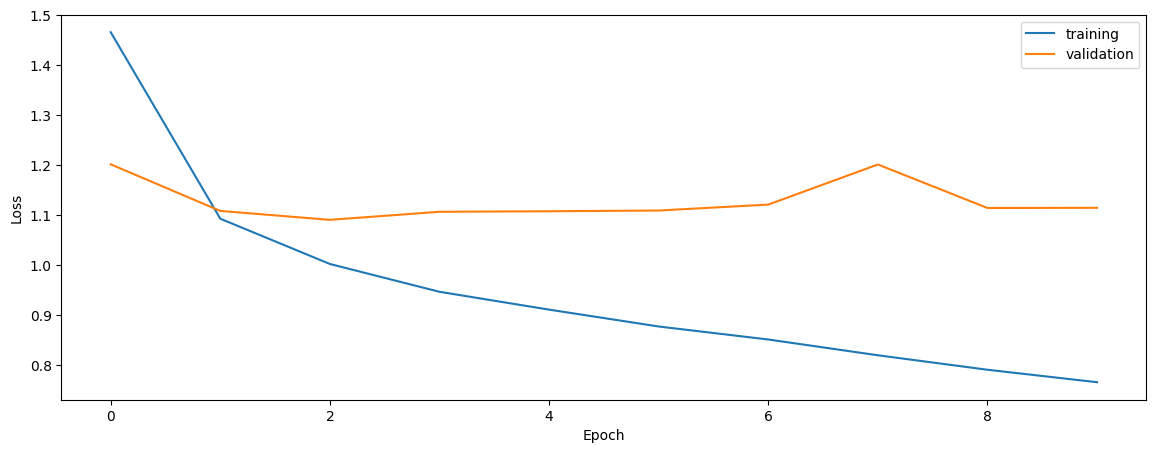

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6233622588798385
0.5644199128232518
0.5719964510629414


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.57440565822496
0.5673407917383821
0.5205815627590419


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5760574662153433
0.5621080426889646
0.5214136820162971


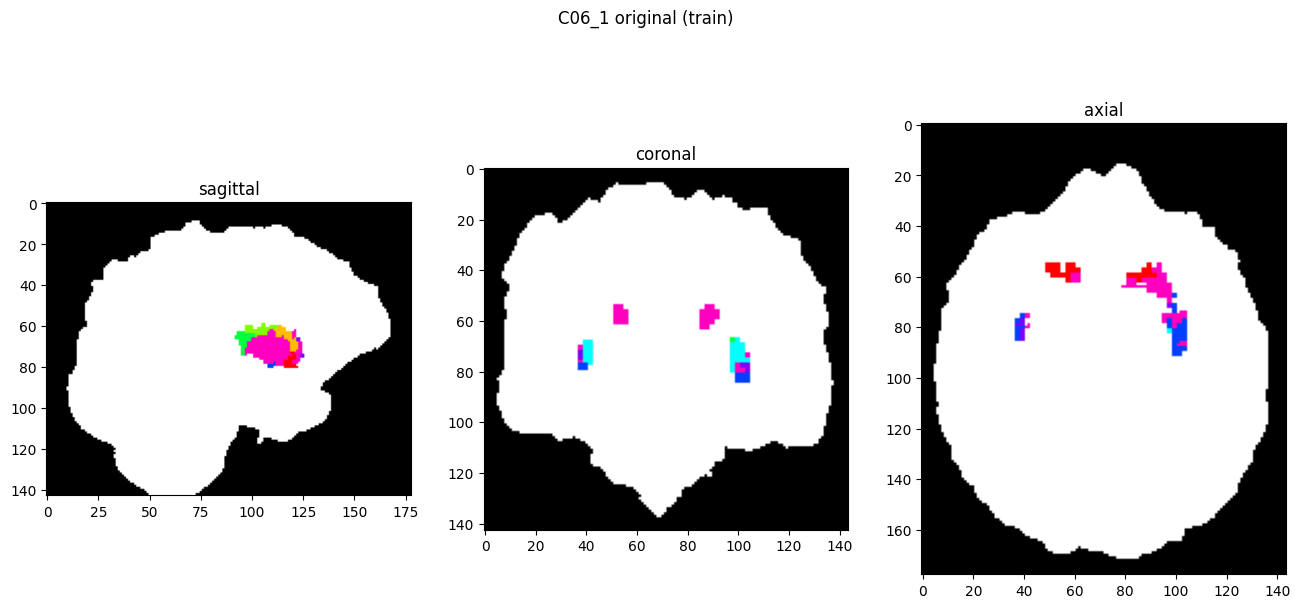

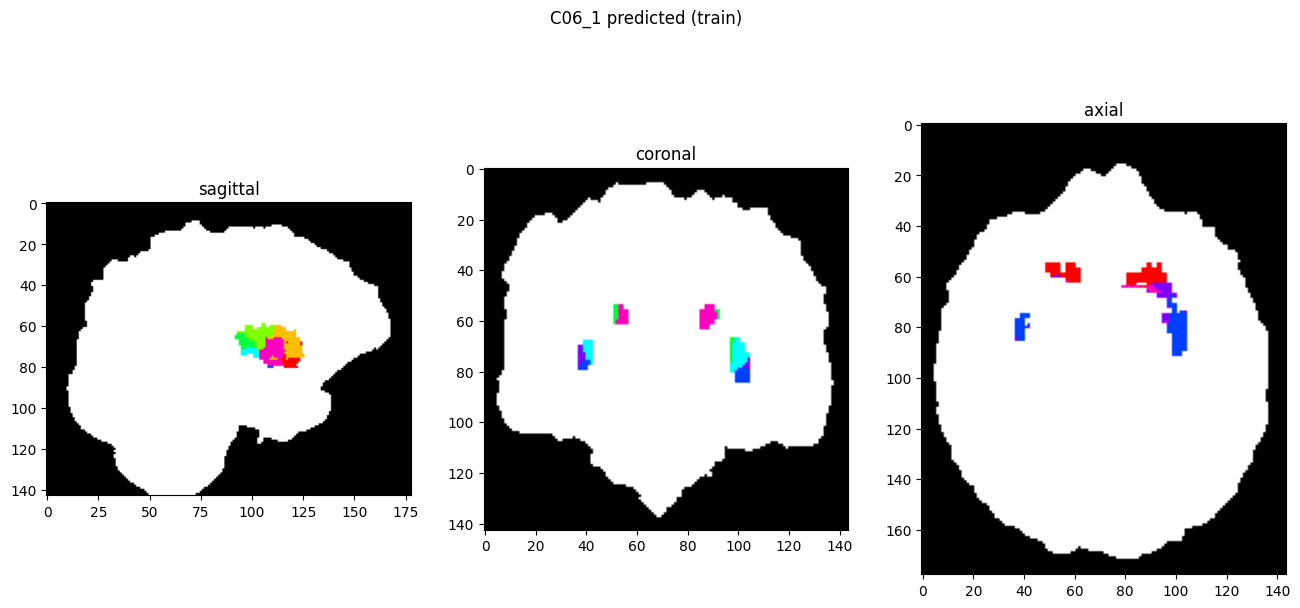

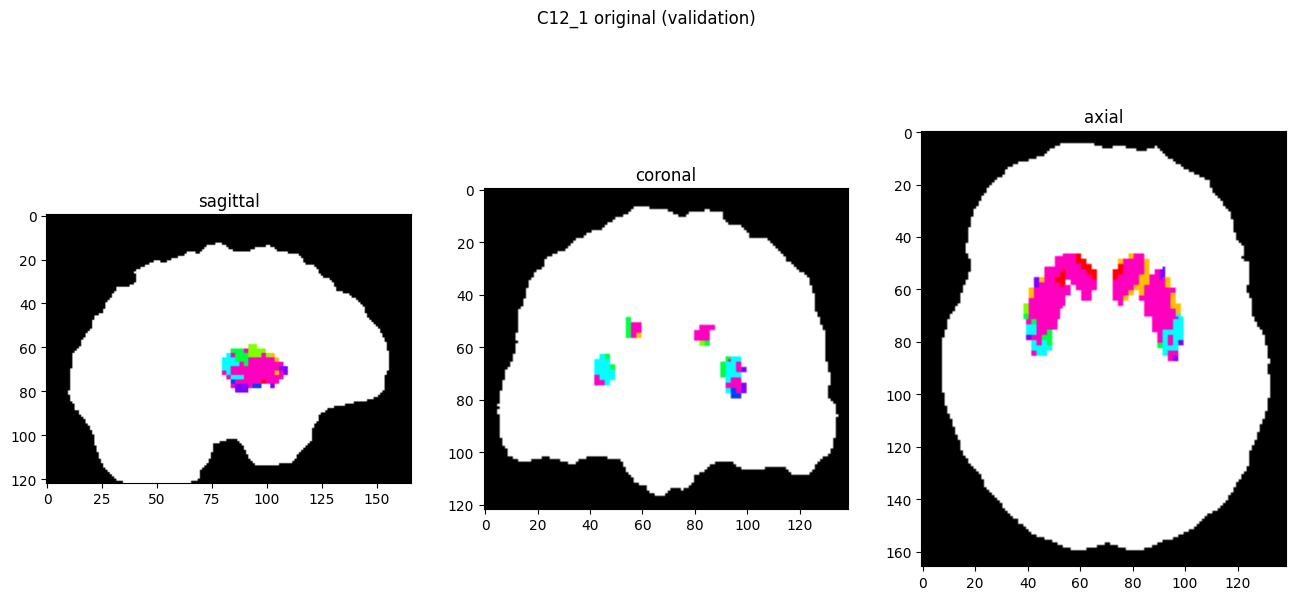

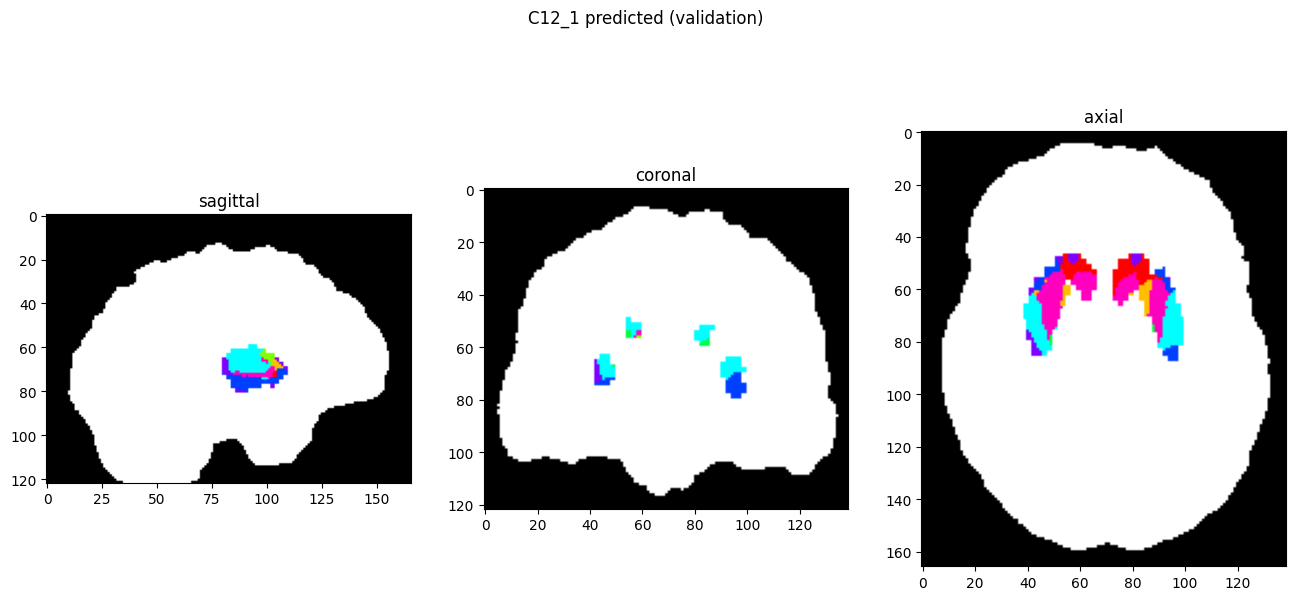

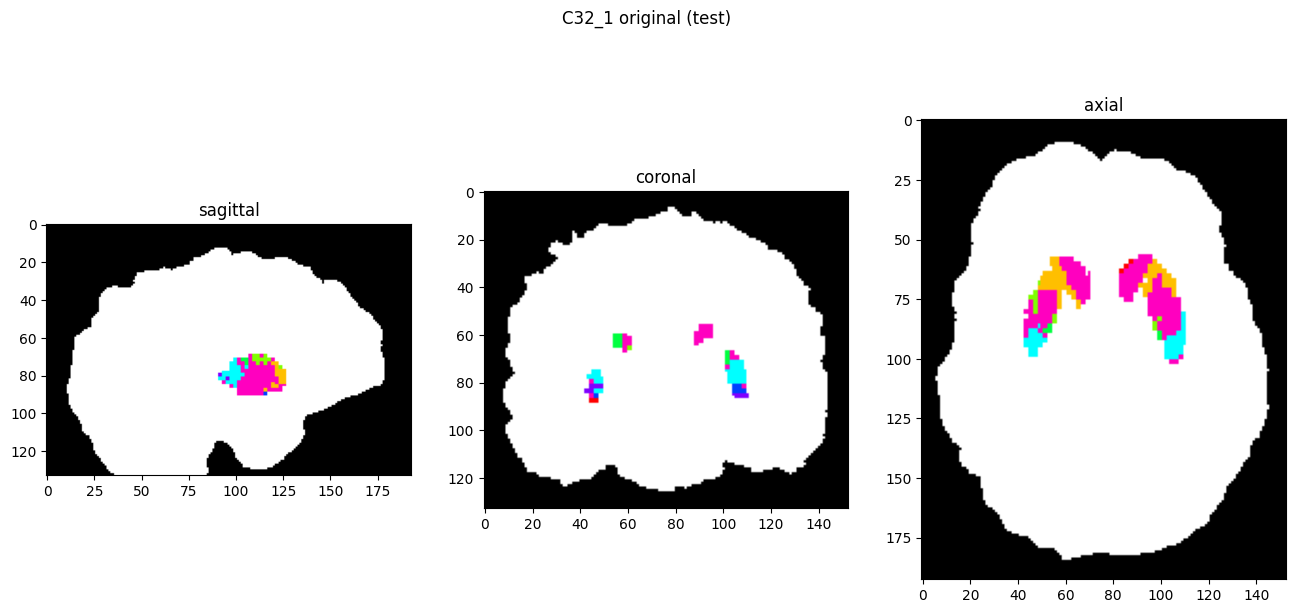

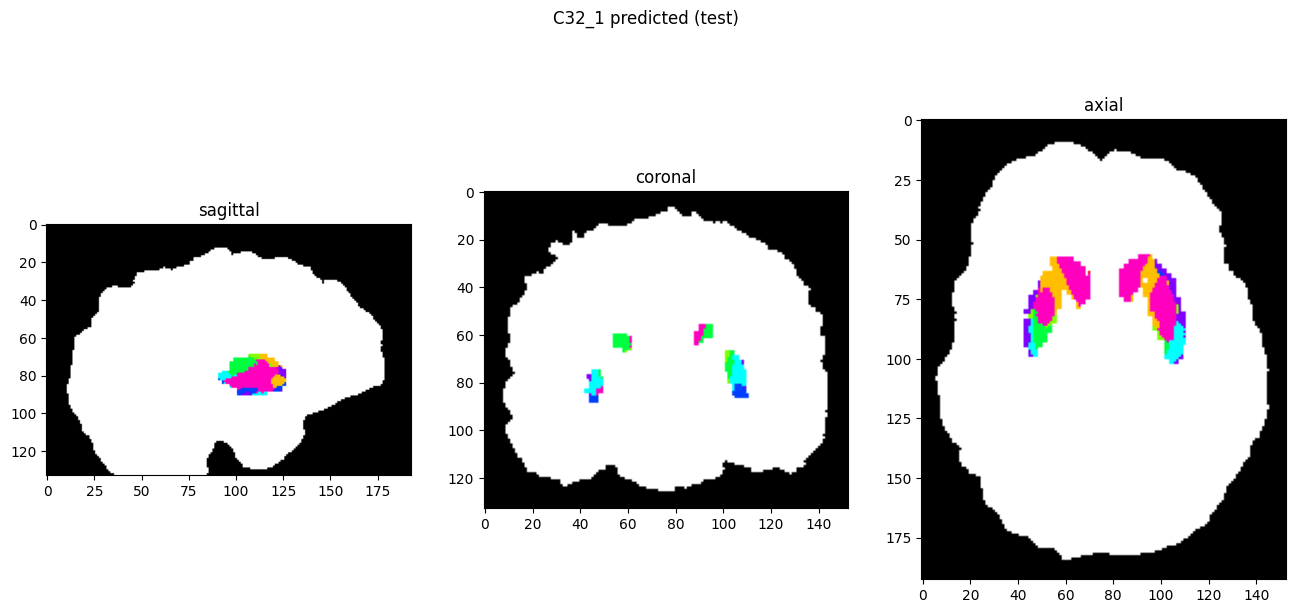

In [10]:
showResults(model, gen, threshold=0)